# Calcium Release Unit (CRU) MCell Model Analysis notebook

##### The notebook is used used to process the data outputted by MCell3 and CellBlender and to create the figures in the 2024 BioPhysical Journal paper entitled:

##### "Stochastic modeling of calcium-induced calcium release in tomographically reconstructed geometries: visualizing cardiomyocyte function and dysfunction at the single molecule level"

##### This notebook was written by Dr. Sophia P. Hirakis, Ph.D. with coding support and guidance from Ray Arvin and Dr. John (Jack) Berkowitz, Ph.D. 


### Importing required packages¶

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.pylab as pylab
from matplotlib.colors import to_rgba
import glob
import os
import operator as op
import pandas as pd
import gc
from itertools import cycle
from scipy import signal
from scipy.signal import butter, filtfilt
from matplotlib.lines import Line2D
from matplotlib.ticker import FuncFormatter

### Defining constants and filenames
<a id='consts'></a>

In [2]:
class data_entry:
    def __init__(self,x,y,s,y_min,y_max):
        self.x=x
        self.y=y
        self.s=s
        self.y_min=y_min
        self.y_max=y_max
        self.y_cd =np.divide(y,y[0])
        

### Locating and naming files

`sims`        - parent directory created from .blend file

`fnames`      - summed average of data, outputted from external python script (see GitHub directory)

`seed_fnames` - raw data outputted from MCell3 simulation

In [3]:
#Defining function that calls on simulation names and files of averages and raw MCell Data

def load_default_settings(custom_prefix=None, custom_suffix=None, custom_fet_prefix=None, custom_fet_suffix=None):
    sims = {
        'default':                    '/cnl/mcelldata/Sophie/2024/',  # <sim name>: <data path>
        'LTCC_10_RyR_off':            '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_10-RyR_off_files',
        'LTCC_40':                    '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_40_files',
        'LTCC_40d':                   '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_40d_files',
        'DefLTCC_10':                 '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_10_files',
        'DefLTCC_10d':                '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_10d_files',
        'DefLTCC_40':                 '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_40_files',
        'DefLTCC_40d':                '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_40d_files',
        'DefLTCC_50':                 '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50_files',
        'DefLTCC_50d':                '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d_files',
        'LTCC_40d':                   '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_40d_files',
        'LTCC_40_Fluo-off':           '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_40-Fluo-off_files',
        'LTCC_40d_Fluo-off':          '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_40d-Fluo-off_files',
        'LTCC_40_RyR_off':            '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_40-RyR_off_files',
        'LTCC_25_RyR_off':            '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_25-RyR_off_files',
        'LTCC_50':                    '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50_files',
        'LTCC_50d':                   '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50d_files',
        'LTCC_50_Fluo-off':           '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50-Fluo-off_files',
        'LTCC_50d_Fluo-off':          '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50d-Fluo-off_files',
        'LTCC_50_RyR_off':            '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50-RyR_off_files',
        'LTCC_50_Fluo-Buffer_off':    '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50-Fluo-off_Buffer-off_files',
        'LTCC_50d_Fluo-Buffer_off':   '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50d-Fluo-off_Buffer-off_files',
        'cJSRLTCC_50':                '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50-CSQN-jSR_files',
        'cJSRLTCC_50d':               '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50d-CSQN-jSR_files',
        'alt5':                       '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',
        'dalt5':                      '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files',
        'L10alt5':                    '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',
        'L25alt5':                    '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',
        'L25dalt5':                   '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files',
        'alt10':                      '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-10_files',
        'DL10alt5':                   '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_10-alt_fact-5_files',
        'L25Dalt5':                   '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files',
        'L25Ddalt5':                  '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files',
        'Dalt5':                      '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files',
        'Ddalt5':                     '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files',
        'Dalt10':                     '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-10_files',
        'falt5':                      '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-Flux_alt_fact-5_files',
        'falt10':                     '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-Flux_alt_fact-10_files',
        'dfalt5':                     '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-Flux_alt_fact-5_files',
        'dfalt10':                    '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-Flux_alt_fact-10_files',
        'csqnoff':                    '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50_CSQN-off_files',
        'csqn075':                    '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50_CSQN_0.75_files',
        'csqn05':                     '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50_CSQN_0.5_files',
        'csqn025':                    '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50_CSQN_0.25_files',
        'Gaur25':                     '/cnl/mcelldata/Sophie/2024/Hirakis_Gaur_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',
        'Gaur50':                     '/cnl/mcelldata/Sophie/2024/Hirakis_Gaur_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',
        'Hake':                       '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Hake_files',
        'Picht':                      '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Picht_files',
        'noAP':                       '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Saftenku-LTCC_50-no_AP_files',
        'RyR_Hake':                   '/cnl/mcelldata/Sophie/2021/Blend_files/RyR_Hake/',
        'RyR_Picht':                  '/cnl/mcelldata/Sophie/2021/Blend_files/RyR_Picht/',
        'no_AP':                      '/cnl/mcelldata/Sophie/2021/Blend_files/no_AP/'
    }
    
        

#Filenames of seed averages
    
    fnames = {
    #Calcium Cyt files
    'cac':  ('Ca2_cyt.World.avg_stddev.dat', 'Average Cytosolic Calcium in world'),
    'cajd':  ('Ca2_cyt.jDyad_sample_volume.avg_stddev.dat', 'Average Cytosolic Calcium in jDyad_sample_volume'),
    #Calcium SR files
    'cas':  ('Ca2_sr.World.avg_stddev.dat', 'Average Cytosolic Calcium in world'),
    'cajs':  ('Ca2_sr.jSR_sample_volume.avg_stddev.dat', 'Average Cytosolic Calcium in jSR_sample_volume'),
    #Alt Calcium Cyt files
    'Cac':  ('Ca_cyt.World.avg_stddev.dat', 'Average Cytosolic Calcium in world'),
    'Cajd':  ('Ca_cyt.jDyad_sample_volume.avg_stddev.dat', 'Average Cytosolic Calcium in jDyad_sample_volume'),
    #Alt Calcium SR files
    'Cas':  ('Ca_sr.World.avg_stddev.dat', 'Average Cytosolic Calcium in world'),
    'Cajs':  ('Ca_sr.jSR_sample_volume.avg_stddev.dat', 'Average Cytosolic Calcium in jSR_sample_volume'),
    #Fluorophores in the World (cytosol) both apo and calcium-bound
    'f5':   ('FLO5_sr.World.avg_stddev.dat', 'Ratio of Fluo5_sr in World'),
    'f5c':  ('FLO5_Ca.World.avg_stddev.dat', 'Ratio of Fluo5_Ca in World'),
    'f4':   ('FLO4_cyt.World.avg_stddev.dat', 'Ratio of Fluo4_cyt in World'),
    'f4c':  ('FLO4_Ca.World.avg_stddev.dat', 'Ratio of Fluo4_Ca in world'),
    #Fluorophores in the Junctions (SR for Fluo5 and Dyad for Fluo4) both apo and calcium-bound
    'f5j':  ('FLO5_sr.jSR_sample_volume.avg_stddev.dat', 'Ratio of Fluo5_sr in jSR_sample_volume'),
    'f5jc': ('FLO5_Ca.jSR_sample_volume.avg_stddev.dat', 'Ratio of Fluo5_sr in jSR_sample_volume'),
    'f4j':  ('FLO4_cyt.jDyad_sample_volume.avg_stddev.dat', 'Ratio of Fluo4_cyt in jDyad_sample_volume'),
    'f4jc': ('FLO4_Ca.jDyad_sample_volume.avg_stddev.dat', 'Ratio of Fluo4_Ca in jDyad_sample_volume'),
    #Buffers in SR
    'csqca': ('CSQN_Ca.World.avg_stddev.dat', 'Average Calcium-bound Calsequestrin in SR'),
    'csq':   ('CSQN_sr.World.avg_stddev.dat', 'Average Calsequestrin in SR'),
    #Buffers in cytosol
    'cmdca': ('CMDN_Ca.World.avg_stddev.dat', 'Average Calcium-bound Calmodulin in cytosol'),
    'cmd':   ('CMDN_cyt.World.avg_stddev.dat', 'Average Calmodulin in cytosol'),
    'trpca': ('TRPN_Ca.World.avg_stddev.dat', 'Average Calcium-bound Troponin-C in cytosol'),
    'trp':   ('TRPN_cyt.World.avg_stddev.dat', 'Average Troponin-C in cytosol'),
    'atpca': ('ATP_Ca.World.avg_stddev.dat', 'Average Calcium-bound ATP in cytosol'),

    #RyR States, open or closed 
    'cRyR':  ('ClosedRyR.avg_stddev.dat', 'Closed RyR'),
    'oRyR':  ('OpenRyR.avg_stddev.dat', 'Open RyR'),
    'lcRyR':  ('LowClosedRyR.avg_stddev.dat', 'Low Gating Closed RyR'),
    'loRyR':  ('LowOpenRyR.avg_stddev.dat', 'Low Gating Open RyR'), 
    'hcRyR':  ('HighClosedRyR.avg_stddev.dat', 'High Gating Closed RyR'),
    'hoRyR':  ('HighOpenRyR.avg_stddev.dat', 'High Gating Open RyR'), 
    #RyR fluxes, efflux or influx 
    'iRyR':  ('InfluxRyR.avg_stddev.dat', 'RyR Influx'),
    'eRyR':  ('EffluxRyR.avg_stddev.dat', 'RyR Efflux'),
    #LTCC states
    'ActLTCC': ('AllActLTCC.avg_stddev.dat' ,'All Active LTCC'),    
    'cInactLTCC': ('CalcInactLTCC.avg_stddev.dat' ,'Calcium Inactivated LTCC'),
    'InactLTCC': ('AllInactLTCC.avg_stddev.dat', 'All Inactivated LTCC'), 
    'vActLTCC': ('VoltActLTCC.avg_stddev.dat', 'Voltage Activated LTCC'),
    'cActLTCC': ('CalcActLTCC.avg_stddev.dat', 'Calcium Activated LTCC'),
    'vInactLTCC': ('VoltInactLTCC.avg_stddev.dat', 'Voltage Inactivated LTCC'),
    #LTCC fluxes, efflux or influx 
    'iLTCC':  ('InfluxLTCC.avg_stddev.dat', 'LTCC Influx'),
    'eLTCC':  ('EffluxLTCC.avg_stddev.dat', 'LTCC Efflux'),
    #SERCA 
    'CaBserca': ('Ca-Bound_SERCA.avg_stddev.dat', 'Calcium-Bound SERCA'),
    'CaFserca': ('Ca-Free_SERCA.avg_stddev.dat', 'Calcium-Free SERCA'),
    #Calcium bound species 
    'CaMols' : ('Ca-Bound_species.avg_stddev.dat', 'Calcium Bound Molecules'),
    'CaOserca': ('Ca_on_SERCA.avg_stddev.dat', 'Calcium on SERCA'),
    'CaCytSpec' : ('Ca_cyt_species.avg_stddev.dat', 'Calcium Bound Molecules'),
    }
    
#Filenames of raw data output directly by MCell 
    
    seed_fnames = {
        #Calcium files
        'cac':  ('Ca2_cyt.World.dat', 'Cytosolic Calcium in world'),
        'cajd':  ('Ca2_cyt.jDyad_sample_volume.dat', 'Cytosolic Calcium in jDyad_sample_volume'),
        #Calcium SR files
        'cas':  ('Ca2_sr.World.dat', 'Cytosolic Calcium in world'),
        'cajs':  ('Ca2_sr.jSR_sample_volume.dat', 'Cytosolic Calcium in jSR_sample_volume'),

        #Alt Calcium files
        'Cac':  ('Ca_cyt.World.dat', 'Cytosolic Calcium in world'),
        'Cajd':  ('Ca_cyt.jDyad_sample_volume.dat', 'Cytosolic Calcium in jDyad_sample_volume'),
        #Alt Calcium SR files
        'Cas':  ('Ca_sr.World.dat', 'Cytosolic Calcium in world'),
        'Cajs':  ('Ca_sr.jSR_sample_volume.dat', 'Cytosolic Calcium in jSR_sample_volume'),
        #Fluorophores in the World (cytosol) both apo and calcium-bound
        'f5':   ('FLO5_sr.World.dat', 'Ratio of Fluo5_sr in World'),
        'f5c':  ('FLO5_Ca.World.dat', 'Ratio of Fluo5_Ca in World'),
        'f4':   ('FLO4_cyt.World.dat', 'Ratio of Fluo4_cyt in World'),
        'f4c':  ('FLO4_Ca.World.dat', 'Ratio of Fluo4_Ca in world'),
        #Fluorophores in the Junctions (SR for Fluo5 and Dyad for Fluo4) both apo and calcium-bound
        'f5j':  ('FLO5_sr.jSR_sample_volume.dat', 'Ratio of Fluo5_sr in jSR_sample_volume'),
        'f5jc': ('FLO5_Ca.jSR_sample_volume.dat', 'Ratio of Fluo5_sr in jSR_sample_volume'),
        'f4j':  ('FLO4_cyt.jDyad_sample_volume.dat', 'Ratio of Fluo4_cyt in jDyad_sample_volume'),
        'f4jc': ('FLO4_Ca.jDyad_sample_volume.dat', 'Ratio of Fluo4_Ca in jDyad_sample_volume'),
        #Buffers
        'atpca':  ('ATP_Ca.World.dat', 'Calcium-Bound ATP in world'),

    }
        
    suffix= '/mcell/output_data/react_data/'

    # default values for prefix and suffix
    dir_prefix = custom_prefix if custom_prefix is not None else 'Hirakis_CRU_RyR-Saftenku_'
    dir_suffix = custom_suffix if custom_suffix is not None else '_files'
    #fet_prefix = custom_fet_prefix if custom_fet_prefix is not None else ''
    #fet_suffix = custom_fet_suffix if custom_fet_suffix is not None else ''
    fet_prefix = custom_fet_prefix if custom_fet_prefix is not None else 'hake_ryr_spark_SRclamp_CaC_fet'
    fet_suffix = custom_fet_suffix if custom_fet_suffix is not None else 'rescale_files'

    # override with custom values if provided
    if custom_prefix is not None:
        dir_prefix = custom_prefix
    if custom_suffix is not None:
        dir_suffix = custom_suffix
    if custom_fet_prefix is not None:
        fet_prefix = custom_fet_prefix
    if custom_fet_suffix is not None:
        fet_suffix = custom_fet_suffix
    
    # existing code to set up suffix
    
    return {
        'sims': sims,
        'fnames': fnames,
        'seed_fnames': seed_fnames,
        'suffix': suffix,
        'dir_prefix': dir_prefix,
        'dir_suffix': dir_suffix,
        'fet_prefix': fet_prefix,  
        'fet_suffix': fet_suffix,
    }
    
healthy_cleft_volume = 2.37e-3  # This is cubic micrometers
deformed_cleft_volume = 4.69e-3

In [4]:
def load_custom_settings(newsettings):
    defaultsettings = load_default_settings()
    return { **defaultsettings, **newsettings}

In [5]:
hake_settings = load_default_settings(
    custom_prefix='hake_ryr_spark_SRclamp_CaC_fet',
    custom_suffix='rescale_files',
    custom_fet_prefix='hake_ryr_spark_SRclamp_CaC_fet',  # These should match the actual fet prefixes you want for hake
    custom_fet_suffix='rescale_files'  # And the fet suffixes for hake
)

saftenku_settings = load_default_settings(
    custom_prefix='saftenku_ryr_spark_SRclamp_CaC_fet',
    custom_suffix='files',
    custom_fet_prefix='saftenku_ryr_spark_SRclamp_CaC_fet',  # These should match the actual fet prefixes you want for saftenku
    custom_fet_suffix='files'  # And the fet suffixes for saftenku
)


### Sorting the files according to defined filenames

In [6]:
def load_data_set(sim, rel, f, scale, settings=None):
    if not settings:
        settings = load_default_settings()

    if rel == 'r5':
        fet = '{}_{}_rel5_{}'.format(
            settings['fet_prefix'],
            scale,
            settings['fet_suffix'])
    else:
        fet = '{}_{}_{}'.format(
            settings['fet_prefix'],
            scale,
            settings['fet_suffix'])

    filename = '{}{}{}{}'.format(
        settings['sims'][sim],
        fet,
        settings['suffix'],
        settings['fnames'][f][0]
    )

    try:
        df = pd.read_csv(
            filename,
            delimiter=' ',
            names=['x', 'y', 's'],
            dtype={'x': np.float64, 'y': np.float64, 's': np.float64}
        )

        df['y_min'] = df['y'] - df['s']
        df['y_max'] = df['y'] + df['s']
        df['y_cd'] = df['y']
        df['y_cd'] = df['y'] / df['y'][0]
        return df
    except IndexError as index_error:
        print('File possibly empty/malformed: {}'.format(filename))
    except FileNotFoundError as fnf_error:
        print('File not found at {}'.format(filename))
        raise fnf_error
    
    
    return None

### Defining normalization function

In [7]:
def normalize_series(series):
    return ( series - series.min() ) / ( series.max() - series.min() )

### Defining comma ticker

In [8]:
def format_axis_with_comma(axis):

    #Apply comma formatting to the y-axis of the given axis object.
    #:param axis: Matplotlib axis object
    
    formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    axis.yaxis.set_major_formatter(formatter)

### Sorting the prefixes and suffixes in order to read `seed_fnames` within the `load_seed_set` function

In [9]:
def load_seed_set(sim, rel, f, scale, seed, settings=None):
    if not settings:
        settings = load_default_settings()

    if rel == 'r5':
        fet = '{}_{}_rel5_{}'.format(
            settings['fet_prefix'],
            scale,
            settings['fet_suffix'])
    else:
        fet = '{}_{}_{}'.format(
            settings['fet_prefix'],
            scale,
            settings['dir_suffix'])

    filename = '{}{}{}{}{}'.format(
        settings['sims'][sim],
        fet,
        settings['suffix'],
        'seed_{0:05d}/'.format(seed),
        settings['seed_fnames'][f][0]
    )

    try:
        df = pd.read_csv(
            filename,
            delimiter=' ',
            names=['x', 'y'],
            dtype={'x': np.float64, 'y': np.float64}
        )
        return df
    except FileNotFoundError as fnf_error:
        print('File not found at {}'.format(filename))
        raise fnf_error

# Add debugging prints here
#print(type(settings['sims']))  # Should print <class 'dict'>
#print(settings['sims'])  # Should print a dictionary




### Defining the Fluoresence function, ΔF/F0

lf5c= Brightness of Bound Fluo5 = 100
lf5= Brightness of Unbound Fluo5 = 1

nBF5= Number of Bound Fluo5 = y1
nUF5= Number of Unbound Fluo5 = y2

FT = lf5c(nBF5) + lf5(nUF5) = Total Fluorescence 
F0 = Total Fluorescence at time zero 
ΔF = FT  - F0

ΔF/F0 = (FT  - F0 )/F0

In [10]:
def calculate_diff_series(fluo_set, fluo_c_set, f, fc, normalize=True):
    # lfs = Multiply {fluo_set} by its light fluo
    lfs = fluo_set['y'] * f
    # lfcs = Multiply {fluo_c_set} by its light fluo
    lfcs = fluo_c_set['y'] * fc
    # tf = total fluorescence
    tf = lfs.add(lfcs, fill_value=0)
    # tf0 = fluorescence at datapoint 0
    tf0 = lfs.at[0] + lfcs.at[0]
    # diff_f = little d
    diff_f = tf-tf0
    # delta_f = overall change
    delta_f = ( diff_f/tf0 )
    # delta f normalized 
    if normalize:
        return ( delta_f / abs( delta_f.min() ) ) + 1
    return delta_f


### Defining forward difference function and filter

In [11]:
dt=1e-6
nyquist_freq=0.5/dt
filter_freq=400.0 # Hz

Wn= filter_freq/nyquist_freq
(filter_b, filter_a) = signal.iirfilter(4,Wn,None,None,'lowpass',0,'bessel','ba') #4 pole bessel filter
(filter_d, filter_c) = signal.iirfilter(4,Wn,None,None,'lowpass',0,'bessel','ba') #4 pole bessel filter

def forward_diff_series(efflux_set, influx_set, Filter=True, Max=True):
    #set forward difference equal to Efflux - Influx
    diff=np.subtract(efflux_set['y'],influx_set['y'])
    #take forward difference
    f_diff=np.diff(diff)
    #get rate of forward difference
    diff_rate=np.divide(f_diff,dt)
    #filter the data
    filt_data=signal.filtfilt(filter_d, filter_c, diff_rate)
    #get the max of the filtered data
    max_filt=np.max(filt_data)
    if Filter:
        return(filt_data)
    if Max:
        return(max_filt)
    return diff_rate

In [12]:
def load_custom_settings(newsettings):
    defaultsettings = load_default_settings()
    
    # Debugging: Print out the type and contents of newsettings['sims']
    print(type(newsettings['sims']))  # Should print <class 'dict'>
    print(newsettings['sims'])  # Should print a dictionary with simulation paths
    
    return {**defaultsettings, **newsettings}

### Looking for maximum and minimum values acoss seeds in chosen simulation 

In [13]:
min_set = []
max_set = []
seeds=list(range(1, 10))
sim='no_AP'
for seed in seeds:
    data_set = load_seed_set(
        sim=sim,
        rel='5',
        scale='0.05',
        f='Cac',
        seed=seed,
        settings=saftenku_settings 
    )

    max_set.append(data_set['y'].max())     #append largest to array of maximums
    min_set.append(data_set['y'].min())     #append smallest to array of minimums

# np.argmax(<array>) returns index of the largest item in array, aka max of all maximums
max_seed = np.argmax(max_set) 
min_seed = np.argmin(min_set)

# Print statements with dynamic simulation name
print('Max seed {1} in dir seed_{0:05d} of {3} sims with value of {2}'.format(seeds[max_seed], seeds[max_seed], np.amax(max_set), sim))
print('Min seed {1} in dir seed_{0:05d} of {3} sims with value of {2}'.format(seeds[min_seed], seeds[min_seed], np.amin(min_set), sim))


Max seed 3 in dir seed_00003 of no_AP sims with value of 92.0
Min seed 4 in dir seed_00004 of no_AP sims with value of 12.0


In [14]:
min_set = []
max_set = []
seeds=list(range(1, 10))
sim='RyR_Hake'
for seed in seeds:
    data_set = load_seed_set(
        sim=sim,
        rel='r5',
        scale='0.05',
        f='Cac',
        seed=seed,
        settings=hake_settings
    )


    max_set.append(data_set['y'].max())     #append largest to array of maximums
    min_set.append(data_set['y'].min())     #append smallest to array of minimums

# np.argmax(<array>) returns index of the largest item in array, aka max of all maximums
max_seed = np.argmax(max_set) 
min_seed = np.argmin(min_set)

# Print statements with dynamic simulation name
print('Max seed {1} in dir seed_{0:05d} of {3} sims with value of {2}'.format(seeds[max_seed], seeds[max_seed], np.amax(max_set), sim))
print('Min seed {1} in dir seed_{0:05d} of {3} sims with value of {2}'.format(seeds[min_seed], seeds[min_seed], np.amin(min_set), sim))


Max seed 2 in dir seed_00002 of RyR_Hake sims with value of 168.0
Min seed 4 in dir seed_00004 of RyR_Hake sims with value of 11.0


In [15]:
def load_seed_set(sim, rel, f, scale, seed, settings):
    # Corrected to access nested dictionary under 'sims'
    if sim not in settings['sims']:
        print(f"Simulation {sim} not found in settings. Available simulations: {list(settings['sims'].keys())}")
        raise KeyError(f"Simulation {sim} not found in settings.")
    
    base_path = settings['sims'][sim]  # Accessing the 'sims' dictionary first
    file_path = f"{base_path}/mcell/output_data/react_data/seed_{seed:05d}/FLO5_Ca.World.dat"
    #print(f"Loading data from: {file_path}")
    
    data = pd.read_csv(file_path, delimiter=' ', skiprows=1, names=['time', 'y'])
    return data


In [16]:
settings = load_default_settings()
#print(settings)

min_set = []
max_set = []
seeds = list(range(1, 25))
sim = 'Hake'  # Change this as needed to test different simulations

for seed in seeds:
    data_set = load_seed_set(
        sim=sim,
        rel='', 
        f='f5c', 
        scale='',
        seed=seed,
        settings=settings
    )

    #print(f"Seed {seed}: Min = {data_set['y'].min()}, Max = {data_set['y'].max()}")

    max_set.append(data_set['y'].max())
    min_set.append(data_set['y'].min())

# Determine the seeds with the max and min values
max_seed = np.argmax(max_set)
min_seed = np.argmin(min_set)

# Output the results
print(f'Max seed {seeds[max_seed]} in dir seed_{seeds[max_seed]:05d} of {sim} sims with value of {np.amax(max_set)}')
print(f'Min seed {seeds[min_seed]} in dir seed_{seeds[min_seed]:05d} of {sim} sims with value of {np.amin(min_set)}')

Max seed 4 in dir seed_00004 of Hake sims with value of 192
Min seed 10 in dir seed_00010 of Hake sims with value of 80


In [17]:
settings = load_default_settings()
#print(settings)

min_set = []
max_set = []
seeds = list(range(1, 25))
sim = 'noAP'  # Change this as needed to test different simulations

for seed in seeds:
    data_set = load_seed_set(
        sim=sim,
        rel='', 
        f='CaC', 
        scale='',
        seed=seed,
        settings=settings
    )

    #print(f"Seed {seed}: Min = {data_set['y'].min()}, Max = {data_set['y'].max()}")

    max_set.append(data_set['y'].max())
    min_set.append(data_set['y'].min())

# Determine the seeds with the max and min values
max_seed = np.argmax(max_set)
min_seed = np.argmin(min_set)

# Output the results
print(f'Max seed {seeds[max_seed]} in dir seed_{seeds[max_seed]:05d} of {sim} sims with value of {np.amax(max_set)}')
print(f'Min seed {seeds[min_seed]} in dir seed_{seeds[min_seed]:05d} of {sim} sims with value of {np.amin(min_set)}')

Max seed 6 in dir seed_00006 of noAP sims with value of 195
Min seed 3 in dir seed_00003 of noAP sims with value of 143


### Loading and sorting healthy and diseased AP and files

In [18]:
prefix='/cnl/mcelldata/Sophie/2024/Action_Potential/'
plot_prefix='/cnl/mcelldata/Sophie/2024/Figures/'

h_AP= 'WildType_AP_interp_Wang_et_al_2013.dat'
label_h_AP = ('Control action potential'
              '\n WT-sham    Wang et al. (2013)')

d_AP= 'Diseased_AP_interp_Wang_et_al_2013.dat'   
label_d_AP = ('Disease action potential, '
              '\n WT-TAC       Wang et al. (2013)')


H_AP= 'k_RyR_Ca_flux.dat'
label_H_AP = 'Hake (100ms) step potential '

P_AP= 'k_RyR_Ca_flux.dat'
label_H_AP = 'Hake (100ms) step potential '


h_AP_file=open(prefix + 'healthy_AP/' + h_AP)
h_AP_data = []
for line in h_AP_file.readlines():
    h_AP_data.append(list(map(float,line.strip().split(' '))))
    
xhAP,yhAP = zip(*h_AP_data)


d_AP_file=open(prefix + 'diseased_AP/' + d_AP)
d_AP_data = []
for line in d_AP_file.readlines():
    d_AP_data.append(list(map(float,line.strip().split(' '))))
    
xdAP,ydAP= zip(*d_AP_data)

### Figure 3D, Action potential comparison

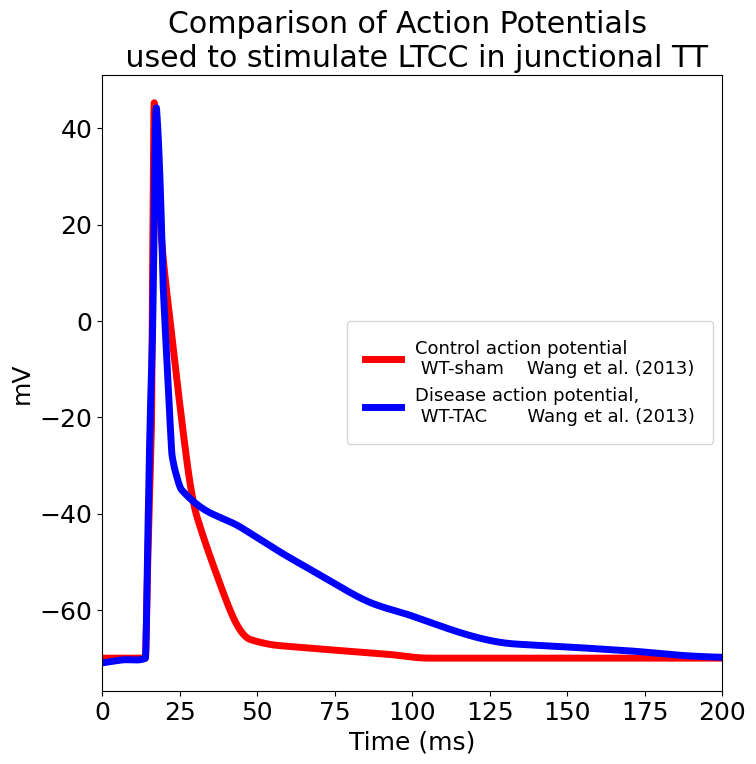

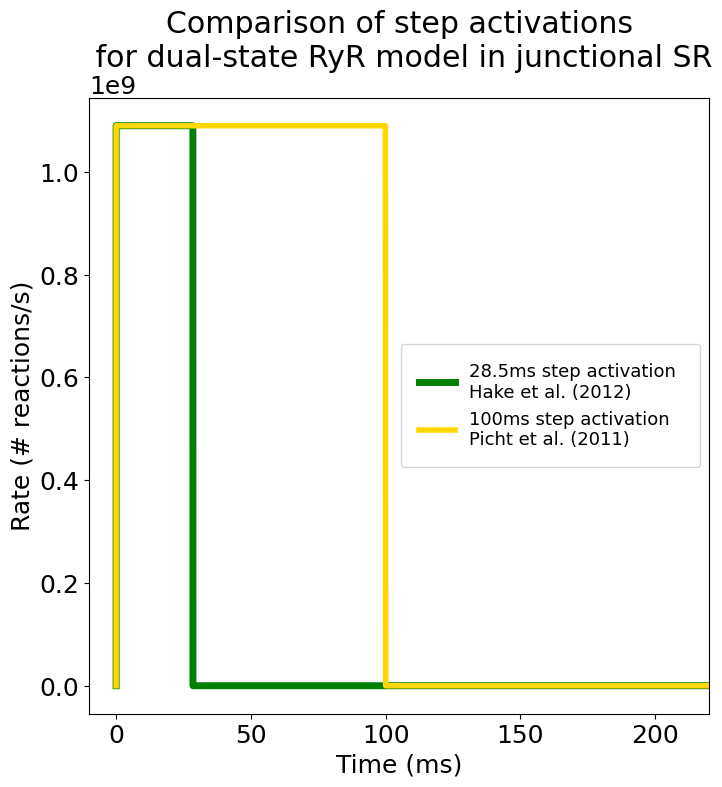

3200

In [19]:
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(8,8))
plt.plot(xhAP,yhAP, 'r', label=label_h_AP, linewidth=5)
plt.plot(xdAP,ydAP, 'b', label=label_d_AP, linewidth=5)
#plt.plot(xHAP,yHAP, 'g', label=label_H_AP, linewidth=4)
plt.xlabel('Time (ms)')
#plt.xlim(8,30)
plt.xlim(0,200)
plt.ylabel('mV')
plt.xlabel('Time (ms)')
plt.title('Comparison of Action Potentials '
          '\n used to stimulate LTCC in junctional TT')
plt.legend(
    loc='center right',
    prop={'size': 13},
    borderpad=1,
    labelspacing=0.5,
    handlelength=2
)
plt.savefig(plot_prefix+'Fig3d_AP.png', dpi=300)
plt.savefig(plot_prefix+'Fig3d_AP.pdf', dpi=300)
plt.show()
gc.collect()  



plt.rcParams.update({'font.size': 18})





plt.figure(figsize=(8,8))
plt.plot([0.0, 0.001, 28.49, 28.5, 220],[0.0, 1.09e9, 1.09e9, 0, 0], 'g', label='28.5ms step activation '
                                                                                '\nHake et al. (2012)', linewidth=5)
plt.plot([0.0, 0.001, 99.9, 100, 220],[0.0, 1.09e9, 1.09e9, 0, 0], 'gold', label='100ms step activation' 
                                                                                 '\nPicht et al. (2011)', linewidth=4)
#plt.plot(xHAP,yHAP, 'g', label=label_H_AP, linewidth=4)
plt.xlabel('Time (ms)')
plt.xlim(-10,220)
plt.ylabel('Rate (# reactions/s)')
plt.xlabel('Time (ms)')
plt.title('Comparison of step activations'
          '\n for dual-state RyR model in junctional SR')
plt.legend(
    loc='center right',
    prop={'size': 13},
    borderpad=1,
    labelspacing=0.5,
    handlelength=2
)
plt.savefig(plot_prefix+'FigSx_stepActivation.png', dpi=300)
plt.savefig(plot_prefix+'FigSx_stepActivation.pdf', dpi=300)
plt.show()
gc.collect() 


## Reload data sets with new naming scheme

In [20]:
def load_data_set(sim, rel, f, scale, settings=None):
    if not settings:
        settings = load_default_settings()

    sim_path = settings['sims'][sim]
    filename_suffix = settings['fnames'][f][0]

    # Only add 'fet' components if 'rel' and 'scale' are provided
    if rel and scale:
        fet_part = '{}_{}_rel{}_{}'.format(settings['fet_prefix'], scale, rel, settings['fet_suffix'])
        filename = '{}{}{}{}'.format(sim_path, fet_part, settings['suffix'], filename_suffix)
    else:
        filename = '{}{}{}'.format(sim_path, settings['suffix'], filename_suffix)

    try:
        df = pd.read_csv(filename, delimiter=' ', names=['x', 'y', 's'], dtype={'x': np.float64, 'y': np.float64, 's': np.float64})
        df['y_min'] = df['y'] - df['s']
        df['y_max'] = df['y'] + df['s']
        df['y_cd'] = df['y'] / df['y'][0]
        return df
    except FileNotFoundError as e:
        print(f'File not found at {filename}')
        raise e
    except Exception as e:
        print(f'An error occurred: {e}')
        raise fnf_error

    return None


## Figure 7a Calcium depletions matched against Picht et. al Hake and Picht stimulii

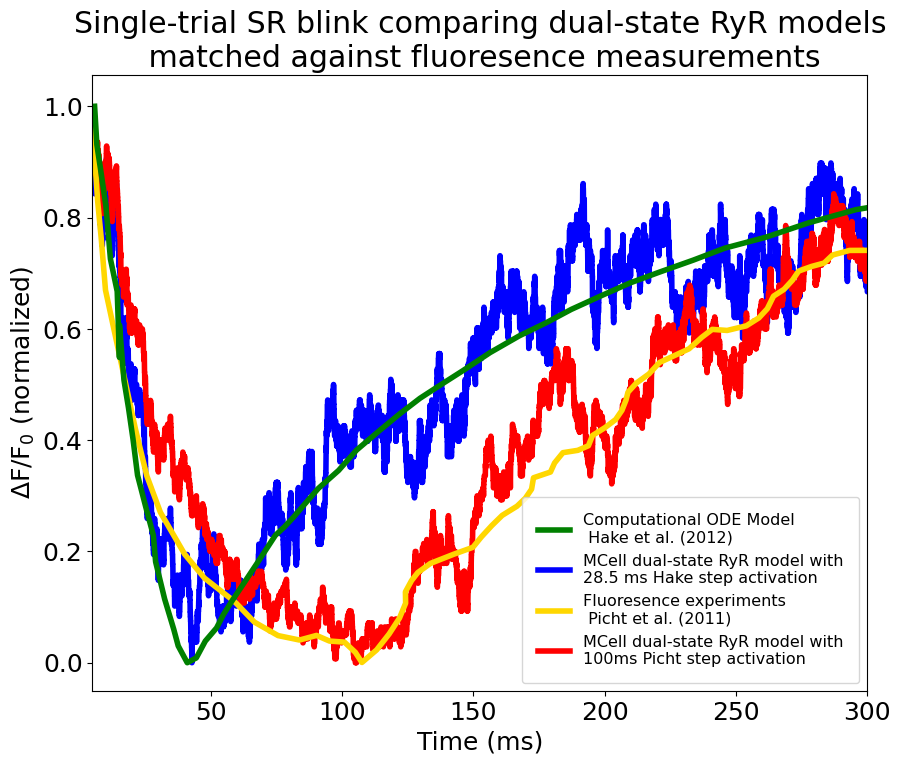

In [21]:
seedn='seed_00006'
# Create the figure
plt.figure(figsize=(10,8))
ms_diff = 5  # Start point for time in ms for Picht data

# Define your data file paths
#hake_path = '/cnl/mcelldata/Sophie/2021/Blend_files/RyR_Hake/hake_ryr_spark_SRclamp_CaC_fet_0.05_rel5_rescale_files/mcell/output_data/react_data/seed_00002/FLO5_Ca.World.dat'
#picht_path = '/cnl/mcelldata/Sophie/2021/Blend_files/RyR_Picht/hake_ryr_spark_SRclamp_CaC_fet_0.05_rel5_rescale_files/mcell/output_data/react_data/seed_00002/FLO5_Ca.World.dat'

hake_path = '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Hake_files/mcell/output_data/react_data/'+seedn+'/FLO5_Ca.World.dat'
picht_path = '/cnl/mcelldata/Sophie/2024/Hirakis_CRU_RyR-Picht_files/mcell/output_data/react_data/'+seedn+'/FLO5_Ca.World.dat'

# Load and plot Hake's MCell data
hake_data = pd.read_csv(hake_path, delimiter=' ', names=['x', 'y'], dtype={'x': np.float64, 'y': np.float64})
normalized_hake_y = (hake_data['y'] - hake_data['y'].min()) / (hake_data['y'].max() - hake_data['y'].min())
time_series_hake = hake_data['x'] * 1000
plt.plot(time_series_hake, normalized_hake_y, color='blue', linewidth=4)

# Load and plot Picht MCell data
picht_data = pd.read_csv(picht_path, delimiter=' ', names=['x', 'y'], dtype={'x': np.float64, 'y': np.float64})
normalized_picht_y = (picht_data['y'] - picht_data['y'].min()) / (picht_data['y'].max() - picht_data['y'].min())
time_series_picht = picht_data['x'] * 1000
plt.plot(time_series_picht, normalized_picht_y, color='red', linewidth=4)

# Plot the Picht et al. (2011) data
fluodata_fsr_frame = pd.read_csv('Picht_Fluodata_FSR.csv', delimiter=',', names=['x', 'y'], dtype={'x': np.float64, 'y': np.float64})
picht_x_15 = ms_diff + fluodata_fsr_frame['x']
plt.plot(picht_x_15, fluodata_fsr_frame['y'], color='gold', linewidth=4)

# Load, sort, and shift Hake et al.'s (2012) dataset
hake_etal_data = pd.read_csv('Hake2012-JPhysiol_Fig5a-Blink.csv', delimiter=',', names=['x', 'y'], dtype={'x': np.float64, 'y': np.float64})
hake_etal_data_sorted = hake_etal_data.sort_values(by='x')
hake_etal_data_sorted['x'] += 5  # Shifting Hake et al.'s data by 12ms
normalized_hake_etal_y = (hake_etal_data_sorted['y'] - hake_etal_data_sorted['y'].min()) / (hake_etal_data_sorted['y'].max() - hake_etal_data_sorted['y'].min())
plt.plot(hake_etal_data_sorted['x'], normalized_hake_etal_y, color='green', linewidth=4)

# Define the custom legend
legend_elements = [
    
    Line2D([0], [0], color='green', lw=4, label='Computational ODE Model''\n Hake et al. (2012)'),
    Line2D([0], [0], color='blue', lw=4, label='MCell dual-state RyR model with''\n28.5 ms Hake step activation'),
    Line2D([0], [0], color='gold', lw=4, label='Fluoresence experiments''\n Picht et al. (2011)'),
    Line2D([0], [0], color='red', lw=4, label='MCell dual-state RyR model with''\n100ms Picht step activation'),
]

# Apply the custom legend
plt.legend(
    handles=legend_elements,
    loc='lower right',
    prop={'size': 11.5},
    borderpad=1,
    labelspacing=0.5,
    handlelength=2
)

# Set the labels and title
plt.xlabel('Time (ms)')
plt.xlim(5, 300)
plt.ylabel(r'$\Delta$F/F$_0$ (normalized)')
plt.title(r'Single-trial SR blink comparing dual-state RyR models'
          '\n matched against fluoresence measurements')

# Save the plot if needed
plt.savefig(plot_prefix+'Fig7a-SingleDyad_Dfonf0_PichtHake.png', dpi=300)
plt.savefig(plot_prefix+'Fig7a-SingleDyad_Dfonf0_PichtHake.pdf', dpi=300)

# Show the plot
plt.show()

# Clear the figure to free memory
plt.clf()
plt.close()


## Figure 7b Calcium depletions matched against Brochet et. al and Two-state and Multi-state RyR models with LTCC 40 and 50

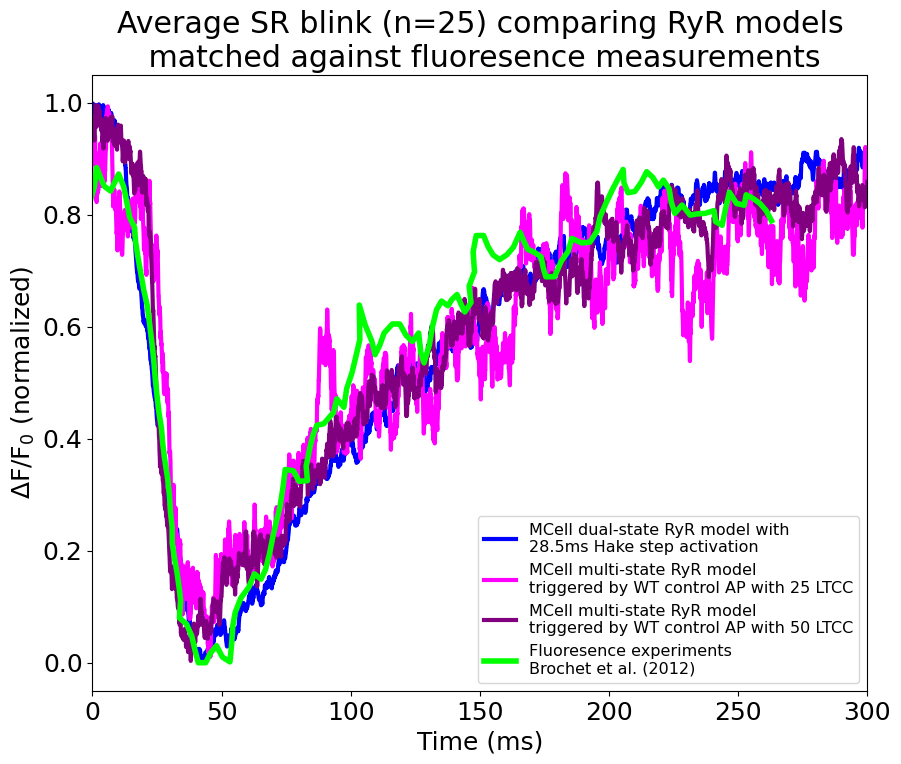

9340

In [22]:
# Function to normalize series
def normalize_series(series):
    return (series - series.min()) / (series.max() - series.min())

# Filter settings
dt = 1e-6
nyquist_freq = 0.5 / dt
filter_freq = 100000  # Hz
Wn = filter_freq / nyquist_freq
filter_d, filter_c = signal.iirfilter(4, Wn, btype='lowpass', ftype='bessel')

# Load and align Brochet data
filename = 'Brochet2012-AdvExpMetBiol_Fig1A-Blink.csv'
brochetdata_fsr_frame = pd.read_csv(filename, delimiter=',', names=['x', 'y'], dtype={'x': np.float64, 'y': np.float64})
x_diff = 48
y_diff = 1
brochet_x_50 = brochetdata_fsr_frame['x'] - x_diff
brochet_y_1 = y_diff + brochetdata_fsr_frame['y']
normalized_y_bro = normalize_series(brochet_y_1)





plt.figure(figsize=(10, 8))

# Plotting setup
custom_colors = [ 'blue',  'magenta', 'purple','red']
sims = ['Hake', 'L25alt5', 'alt5',]# 'LTCC_40']
custom_labels = ['MCell dual-state RyR model with''\n28.5ms Hake step activation', 'MCell multi-state RyR model''\ntriggered by WT control AP with 25 LTCC', 'MCell multi-state RyR model''\ntriggered by WT control AP with 50 LTCC',]



# Plot systems
for sim, color, label in zip(sims, custom_colors, custom_labels):
    data_set = load_data_set(sim=sim, rel='', f='f5c', scale='', settings=settings)
    normalized_y_cd = normalize_series(data_set['y_cd'])
    filt_norm_y = signal.filtfilt(filter_d, filter_c, normalized_y_cd)
    plt.plot(data_set['x'] * 1000, filt_norm_y, color=color, label=label, linewidth=3)
    

#Plot normalized and base shifted Data from Brochet et al 
plt.plot(brochet_x_50, normalized_y_bro, label='Fluoresence experiments''\nBrochet et al. (2012)', color='lime', linewidth=4)


# Additional plot settings and saving
plt.xlabel('Time (ms)')
plt.xlim(0, 300)
plt.ylabel(r'$\Delta$F/F$_0$ (normalized)')
plt.title(r'Average SR blink (n=25) comparing RyR models'
          '\n matched against fluoresence measurements')
plt.legend(loc='lower right', prop={'size': 11.5})
plt.savefig(plot_prefix+'Fig7b_Brochet_Dfonf0_HakeLTCC50.png', dpi=300)
plt.savefig(plot_prefix+'Fig7b_Brochet_Dfonf0_HakeLTCC50.pdf', dpi=300)
plt.show()
gc.collect()


## Figure 8a Number of Activated RyR in Absence of action potential (no_AP)

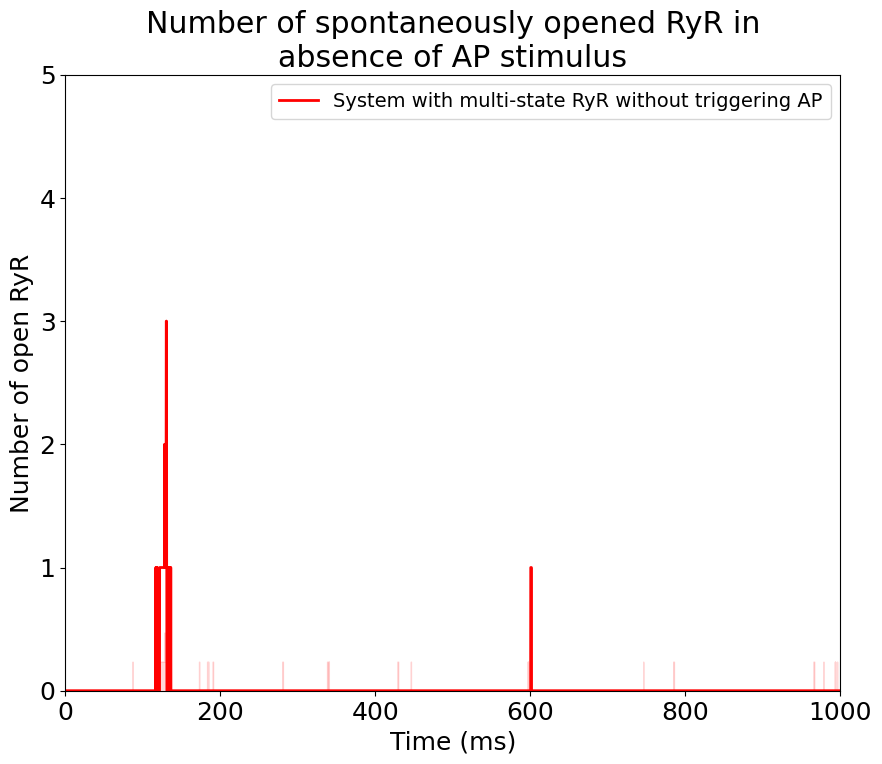

2884

In [23]:
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.5):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_paths = [
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO1_L.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO2_L.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO3_L.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO1_H1.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO2_H1.World.dat',
    ]
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/OpenRyR.avg_stddev.dat'

    # Load the individual data
    individual_data_frames = [load_data(path) for path in individual_file_paths]

    # Check if the time columns in both data sets are identical
    if individual_data_frames[0][0].equals(individual_data_frames[1][0]):
        # Sum the counts of open LTCC
        summed_ltcc = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1] + individual_data_frames[4][1] 
        # Convert time from seconds to milliseconds
        time_in_ms = individual_data_frames[0][0] * 1000
        # Plot individual data
        plt.plot(time_in_ms, summed_ltcc, label=label, color=color, linewidth=2)
    else:
        print(f"Time points are not aligned for {label}.")

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.15)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2021/Blend_files/no_AP'

# Seeds to plot
seed = 20# or any other seed you want to analyze

# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [
    ('saftenku_ryr_spark_SRclamp_CaC_fet_0.05_files', 'System with multi-state RyR without triggering AP', 'red', get_lighter_color('red')),
#    ('Hirakis_CRU_RyR-Saftenku-LTCC_40_files', 'System with 40 LTCC, control AP', 'orange', get_lighter_color('orange')),
#    ('Hirakis_CRU_RyR-Saftenku-LTCC_40d_files', 'System with 40 LTCC, disease AP', 'black', get_lighter_color('black')),
#    ('Hirakis_CRU_RyR-Saftenku-LTCC_10-RyR_off_files', 'System with 10 LTCC, control AP', 'magenta', get_lighter_color('magenta'))
    # Add more conditions here if needed
]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.ylim(0, 2.5)
plt.xlim(0, 1000)
#plt.xticks([15, 20, 25, 30])
plt.yticks([0, 1, 2, 3, 4, 5 ])
plt.legend(loc='upper right', prop={'size': 14})
plt.ylabel('Number of open RyR')
plt.title('Number of spontaneously opened RyR in''\nabsence of AP stimulus')
plt.savefig(plot_prefix+'Fig8a_openRyR-spread.png', dpi=300)
plt.savefig(plot_prefix+'Fig8a_openRyR-spread.pdf', dpi=300)
plt.show()
gc.collect()

## Figure 8b Number of Free calcium ions in dyadic junction in absence of action potential (no_AP)

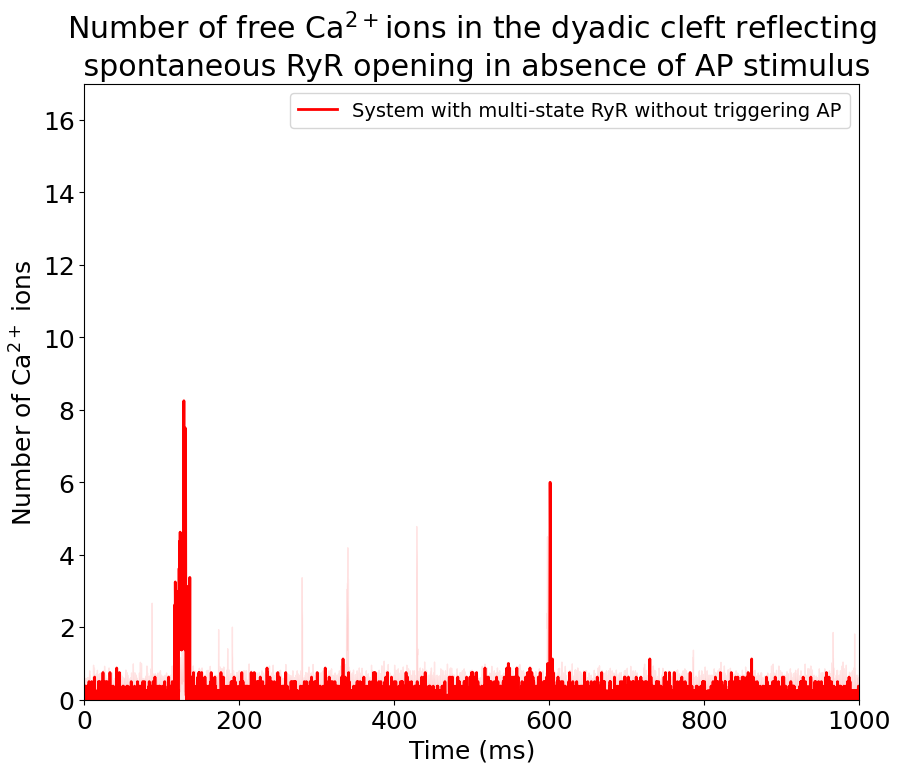

In [24]:
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def moving_average(data, window_size):
    # Apply a simple moving average filter
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.jDyad_sample_volume.dat'
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/Ca_cyt.jDyad_sample_volume.avg_stddev.dat'

    # Load the individual data
    individual_data = load_data(individual_file_path)
    time_in_ms = individual_data[0] * 1000  # Convert time to milliseconds

    # Apply moving average filter
    window_size = 8  # Adjust as needed
    filtered_signal_full = moving_average(individual_data[1], window_size)
    filtered_time_full = moving_average(time_in_ms, window_size)  # Adjust time axis for filtered data

    # Select every 15th point for plotting the individual data
    filtered_signal = filtered_signal_full[::15]
    filtered_time = filtered_time_full[::15]

    plt.plot(filtered_time, filtered_signal, label=label, color=color, linewidth=2)

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Select every 15th point for plotting the average data
    avg_time_in_ms = avg_time_in_ms[::15]
    avg_values = avg_values[::15]
    stddev_values = stddev_values[::15]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.1)

def get_lighter_color(color, alpha=0.2):
    # Get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2021/Blend_files/no_AP'

# Seeds to plot
seed = 20  # or any other seed you want to analyze

# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [
    ('saftenku_ryr_spark_SRclamp_CaC_fet_0.05_files', 'System with multi-state RyR without triggering AP', 'red', get_lighter_color('red')),
    # Add more conditions here if needed
]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.ylim(0, 17)
plt.xlim(0, 1000)
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
plt.ylabel('Number of Ca$^{2+}$ ions')
plt.title(r'Number of free Ca$^{2+}$ions in the dyadic cleft reflecting'
          '\n spontaneous RyR opening in absence of AP stimulus')
plt.legend(loc='upper right', prop={'size': 14})

# Save the plot
plt.savefig(plot_prefix + 'Fig8b_NumCa-spread.png', dpi=300)
plt.savefig(plot_prefix + 'Fig8b_NumCa-spread.pdf', dpi=300)

# Show the plot
plt.show()

# Clear the figure to free memory
plt.clf()
plt.close('all')


## Figure 9A Number of Activated LTCC in Absence of RyR

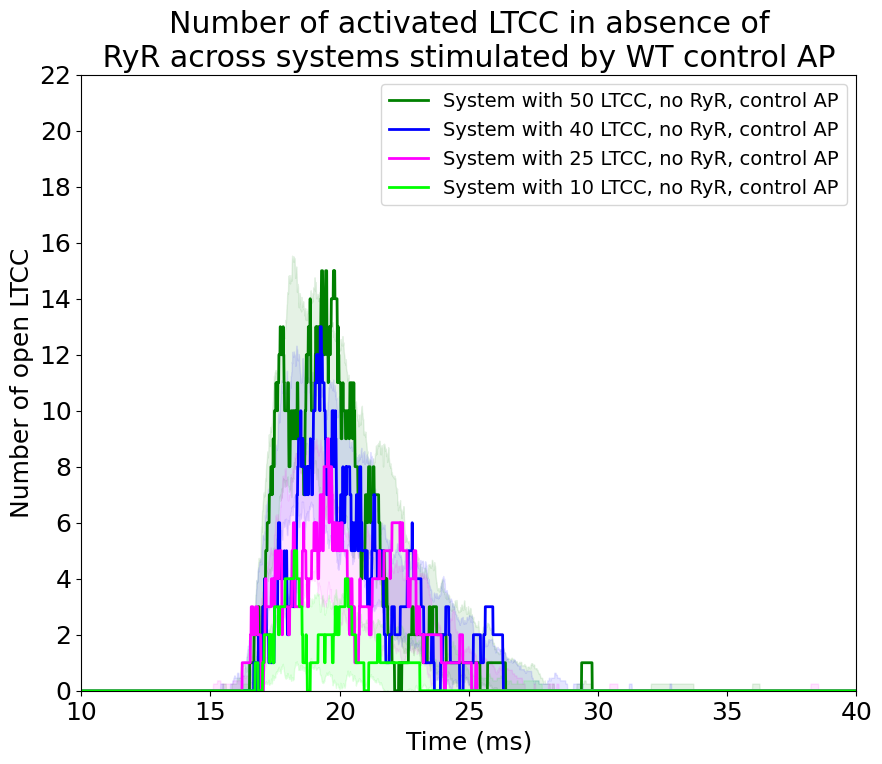

7374

In [25]:
#Figure 8a
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.2):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_paths = [
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_N6.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_Ca12.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_N6i.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_Ca12i.World.dat'
    ]
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/AllActLTCC.avg_stddev.dat'

    # Load the individual data
    individual_data_frames = [load_data(path) for path in individual_file_paths]

    # Check if the time columns in both data sets are identical
    if individual_data_frames[0][0].equals(individual_data_frames[1][0]):
        # Sum the counts of open LTCC
        summed_ltcc = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1]
        # Convert time from seconds to milliseconds
        time_in_ms = individual_data_frames[0][0] * 1000
        # Plot individual data
        plt.plot(time_in_ms, summed_ltcc, label=label, color=color, linewidth=2)
    else:
        print(f"Time points are not aligned for {label}.")

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.1)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot
seed = 3 # or any other seed you want to analyze

# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [
    ('Hirakis_CRU_RyR-Saftenku-LTCC_50-RyR_off_files', 'System with 50 LTCC, no RyR, control AP', 'green', get_lighter_color('green')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_40-RyR_off_files', 'System with 40 LTCC, no RyR, control AP', 'blue', get_lighter_color('blue')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_25-RyR_off_files', 'System with 25 LTCC, no RyR, control AP', 'magenta', get_lighter_color('magenta')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_10-RyR_off_files', 'System with 10 LTCC, no RyR, control AP', 'lime', get_lighter_color('lime'))
    # Add more conditions here if needed
]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(10, 40)
plt.ylim(0, 22)
plt.xticks([ 10, 15, 20, 25, 30, 35, 40])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
plt.ylabel('Number of open LTCC')
plt.title('Number of activated LTCC in absence of'
          '\n RyR across systems stimulated by WT control AP ')
plt.legend(loc='upper right', prop={'size': 14})
plt.savefig(plot_prefix+'Fig9a_actLTCC-spread.png', dpi=300)
plt.savefig(plot_prefix+'Fig9a_actLTCC-spread.pdf', dpi=300)
plt.show()
gc.collect()


## Figure 9b Contribution of LTCC to cytosolic Calcium in junctional SR

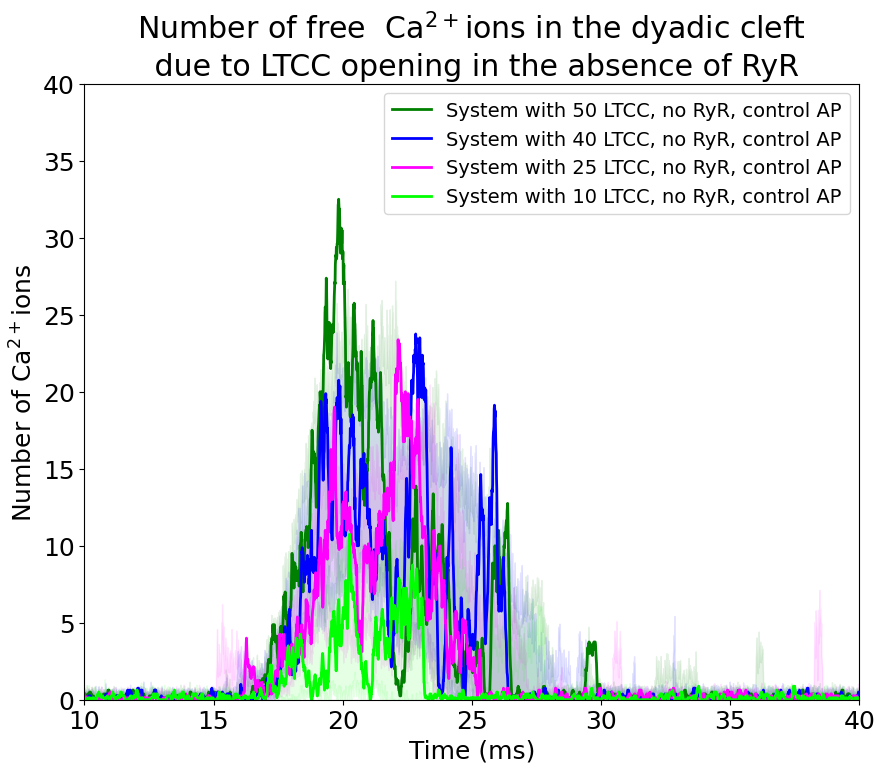

In [26]:
#Figure 8b
## Contribution of LTCC to cytosolic Calcium in junctional SR

def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def moving_average(data, window_size):
    # Apply a simple moving average filter
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.jDyad_sample_volume.dat'
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/Ca_cyt.jDyad_sample_volume.avg_stddev.dat'

    # Load the individual data
    individual_data = load_data(individual_file_path)
    time_in_ms = individual_data[0] * 1000  # Convert time to milliseconds

    # Apply moving average filter
    window_size = 8  # Adjust as needed
    filtered_signal = moving_average(individual_data[1], window_size)
    filtered_time = moving_average(time_in_ms, window_size)  # Adjust time axis for filtered data

    plt.plot(filtered_time, filtered_signal, label=label, color=color, linewidth=2)

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.1)

def get_lighter_color(color, alpha=0.2):
    # Get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot
seed = 3 # Update this to the seed you want to analyze

# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [
    ('Hirakis_CRU_RyR-Saftenku-LTCC_50-RyR_off_files', 'System with 50 LTCC, no RyR, control AP', 'green', get_lighter_color('green')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_40-RyR_off_files', 'System with 40 LTCC, no RyR, control AP', 'blue', get_lighter_color('blue')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_25-RyR_off_files', 'System with 25 LTCC, no RyR, control AP', 'magenta', get_lighter_color('magenta')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_10-RyR_off_files', 'System with 10 LTCC, no RyR, control AP', 'lime', get_lighter_color('lime'))
    # Add more conditions here if needed
]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(10, 40)
plt.ylim(0, 40)
plt.ylabel('Number of Ca$^{2+}$ions')
plt.xticks([10, 15, 20, 25, 30, 35, 40])
plt.title(r'Number of free  Ca$^{2+}$ions in the dyadic cleft'
          '\n due to LTCC opening in the absence of RyR')
plt.legend(loc='upper right', prop={'size': 14})
plt.savefig(plot_prefix+'Fig9b_NumCa-spread.png', dpi=300)
plt.savefig(plot_prefix+'Fig9b_NumCa-spread.pdf', dpi=300)
plt.show()



## Figure 9c Cytosolic Calcium concentration in junctional SR

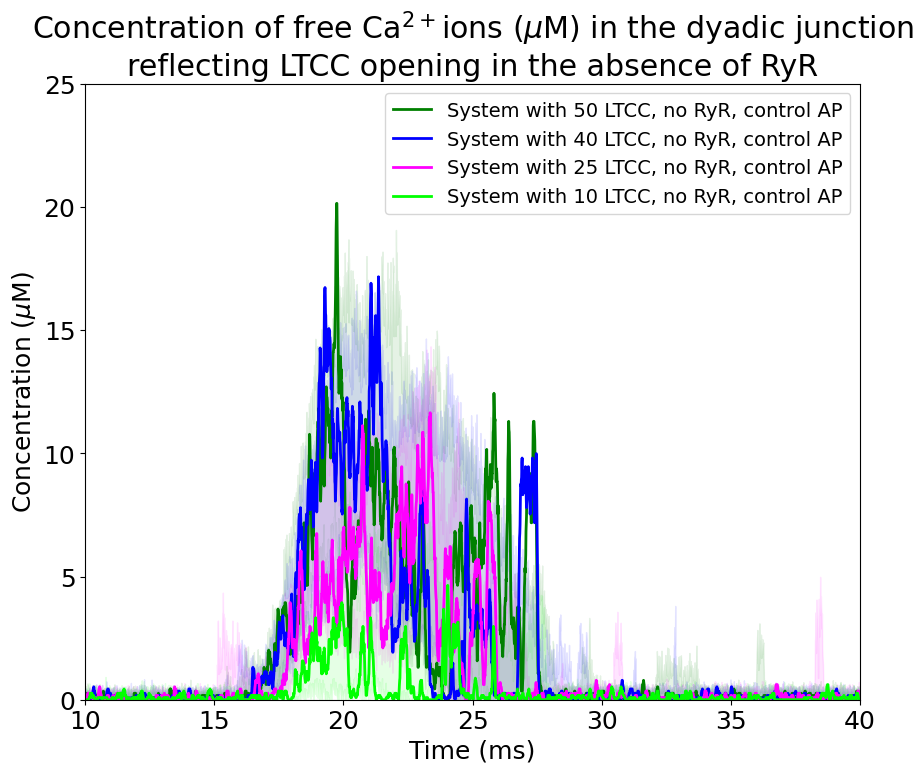

12510

In [27]:
healthy_cleft_volume = 2.37e-3  # Assuming this is in cubic micrometers
deformed_cleft_volume = 4.69e-3

def load_data(file_path):
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def normalize_data_to_micromolarity(data, volume_in_cubic_micrometers):
    volume_in_liters = volume_in_cubic_micrometers * 1e-15
    micromolarity_data = (data / (volume_in_liters * 6.022e23)) * 1e6
    return micromolarity_data

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color):
    volume = healthy_cleft_volume if 'RyR_off' in condition_folder else deformed_cleft_volume
    
    individual_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.jDyad_sample_volume.dat'
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/Ca_cyt.jDyad_sample_volume.avg_stddev.dat'

    individual_data = load_data(individual_file_path)
    time_in_ms = individual_data[0] * 1000
    individual_micromolarity = normalize_data_to_micromolarity(individual_data[1], volume)
    
    window_size = 8
    filtered_individual_micromolarity = moving_average(individual_micromolarity, window_size)
    filtered_time_in_ms = moving_average(time_in_ms, window_size)

    plt.plot(filtered_time_in_ms, filtered_individual_micromolarity, label=label, color=color, linewidth=2)

    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000
    avg_micromolarity = normalize_data_to_micromolarity(avg_data[1], volume)
    stddev_micromolarity = normalize_data_to_micromolarity(avg_data[2], volume)
    
    plt.fill_between(avg_time_in_ms, avg_micromolarity - stddev_micromolarity, avg_micromolarity + stddev_micromolarity, color=shade_color, alpha=0.1)

base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot
#seed = 9 # or any other seed you want to analyze
seed = 7
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [
    ('Hirakis_CRU_RyR-Saftenku-LTCC_50-RyR_off_files', 'System with 50 LTCC, no RyR, control AP', 'green', get_lighter_color('green')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_40-RyR_off_files', 'System with 40 LTCC, no RyR, control AP', 'blue', get_lighter_color('blue')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_25-RyR_off_files', 'System with 25 LTCC, no RyR, control AP', 'magenta', get_lighter_color('magenta')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_10-RyR_off_files', 'System with 10 LTCC, no RyR, control AP', 'lime', get_lighter_color('lime'))
]

for condition_folder, label, color, shade_color in conditions:
    plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.ylabel('Concentration ($\mu$M)')
# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(10, 40)
plt.ylim(0, 25)
plt.yticks([0, 5, 10, 15, 20, 25 ])
plt.title('Concentration of free Ca$^{2+}$ions ($\mu$M) in the dyadic junction' 
          '\nreflecting LTCC opening in the absence of RyR')
plt.legend(loc='upper right', prop={'size': 14})
plt.savefig(plot_prefix+'Fig9c_ConcCa-spread.png', dpi=300)
plt.savefig(plot_prefix+'Fig9c_ConcCa-spread.pdf', dpi=300)
plt.legend(loc='upper right', prop={'size': 14})
plt.show()
gc.collect()

# Comparing numbers of buffering species across simulations

In [36]:
simA='L25alt5'
simB='L25dalt5'

# List of data types
data_types = ['Cac', 'cmd', 'cmdca', 'trp', 'trpca', 'f4', 'f4c', 'CaBserca', 'CaFserca', 'csq', 'csqca', 'f5', 'f5c','Cas']
simulation_cases = [simA, simB]
def load_and_process_data(sim):
    # Function to load data and calculate max-min difference as an integer
    def calc_diff(data_type):
        data = load_data_set(sim=sim, rel='', f=data_type, scale='', settings=saftenku_settings)
        return int(np.max(data['y']) - np.min(data['y']))

    # Load and process data for all types
    return {dt: calc_diff(dt) for dt in data_types}

# Calculate results for each simulation case
results = {sim: load_and_process_data(sim) for sim in simulation_cases}

# Function to calculate total change as an integer
def calc_total_change(sim_results, types):
    return int(sum(sim_results[dt] for dt in types if dt in sim_results))

# Print results
for sim, sim_results in results.items():
    print(f"\nResults for {sim} simulations:")
    print("")
    for data_type, diff in sim_results.items():
        print(f"The difference of {data_type.upper()} is: {diff}")
    print("----------------------------------------------------")
    print(f"The net change in Cytosolic calcium species is: {calc_total_change(sim_results, ['cmdca', 'trpca', 'f4c', 'Cac', 'CaBserca',])}")
    print("")
    print("______________________________________________________________________")
    #print(f"The net change in Sarcoplasmic Reticulum calcium species is: {calc_total_change(sim_results, ['csqca', 'f5c', 'Cas'])}")


def load_and_process_data(sim):
    # Function to load data and calculate max-min difference
    def calc_diff(data_type):
        data = load_data_set(sim=sim, rel='', f=data_type, scale='', settings=saftenku_settings)
        return np.max(data['y']) - np.min(data['y'])

    # Load and process data for all types
    return {dt: calc_diff(dt) for dt in data_types}

# Calculate results for each simulation case
results = {sim: load_and_process_data(sim) for sim in simulation_cases}

# Function to calculate the difference between two simulation cases for each data type
def calculate_differences_between_cases(results, data_types):
    differences = {}
    for dt in data_types:
        if dt in results[simA] and dt in results[simB]:
            diff = results[simA][dt] - results[simB][dt]
            differences[dt] = int(diff)  # Convert to integer
    return differences

# Calculate differences between 'LTCC_50' and 'LTCC_50d'
case_differences = calculate_differences_between_cases(results, data_types)

print ("")
print ("Differences between simulation cases:")
print ("")
# Check if pairs are equal (e.g., 'cmd' and 'cmdca')
pairs = [('cmd', 'cmdca'), ('trp', 'trpca'), ('f4', 'f4c'), ('csq', 'csqca'), ('f5', 'f5c')]
for pair in pairs:
    if all(p in case_differences for p in pair) and case_differences[pair[0]] == case_differences[pair[1]]:
        print(f"The differences for {pair[0].upper()} and {pair[1].upper()} equal to {case_differences[pair[0]]}")




Results for L25alt5 simulations:

The difference of CAC is: 87
The difference of CMD is: 140
The difference of CMDCA is: 140
The difference of TRP is: 562
The difference of TRPCA is: 562
The difference of F4 is: 540
The difference of F4C is: 540
The difference of CABSERCA is: 1025
The difference of CAFSERCA is: 1024
The difference of CSQ is: 5155
The difference of CSQCA is: 5155
The difference of F5 is: 22
The difference of F5C is: 22
The difference of CAS is: 3421
----------------------------------------------------
The net change in Cytosolic calcium species is: 2354

______________________________________________________________________

Results for L25dalt5 simulations:

The difference of CAC is: 99
The difference of CMD is: 131
The difference of CMDCA is: 131
The difference of TRP is: 500
The difference of TRPCA is: 500
The difference of F4 is: 458
The difference of F4C is: 458
The difference of CABSERCA is: 874
The difference of CAFSERCA is: 879
The difference of CSQ is: 4061
Th

# Figure SX Alteration of AP effects on endogenous buffers

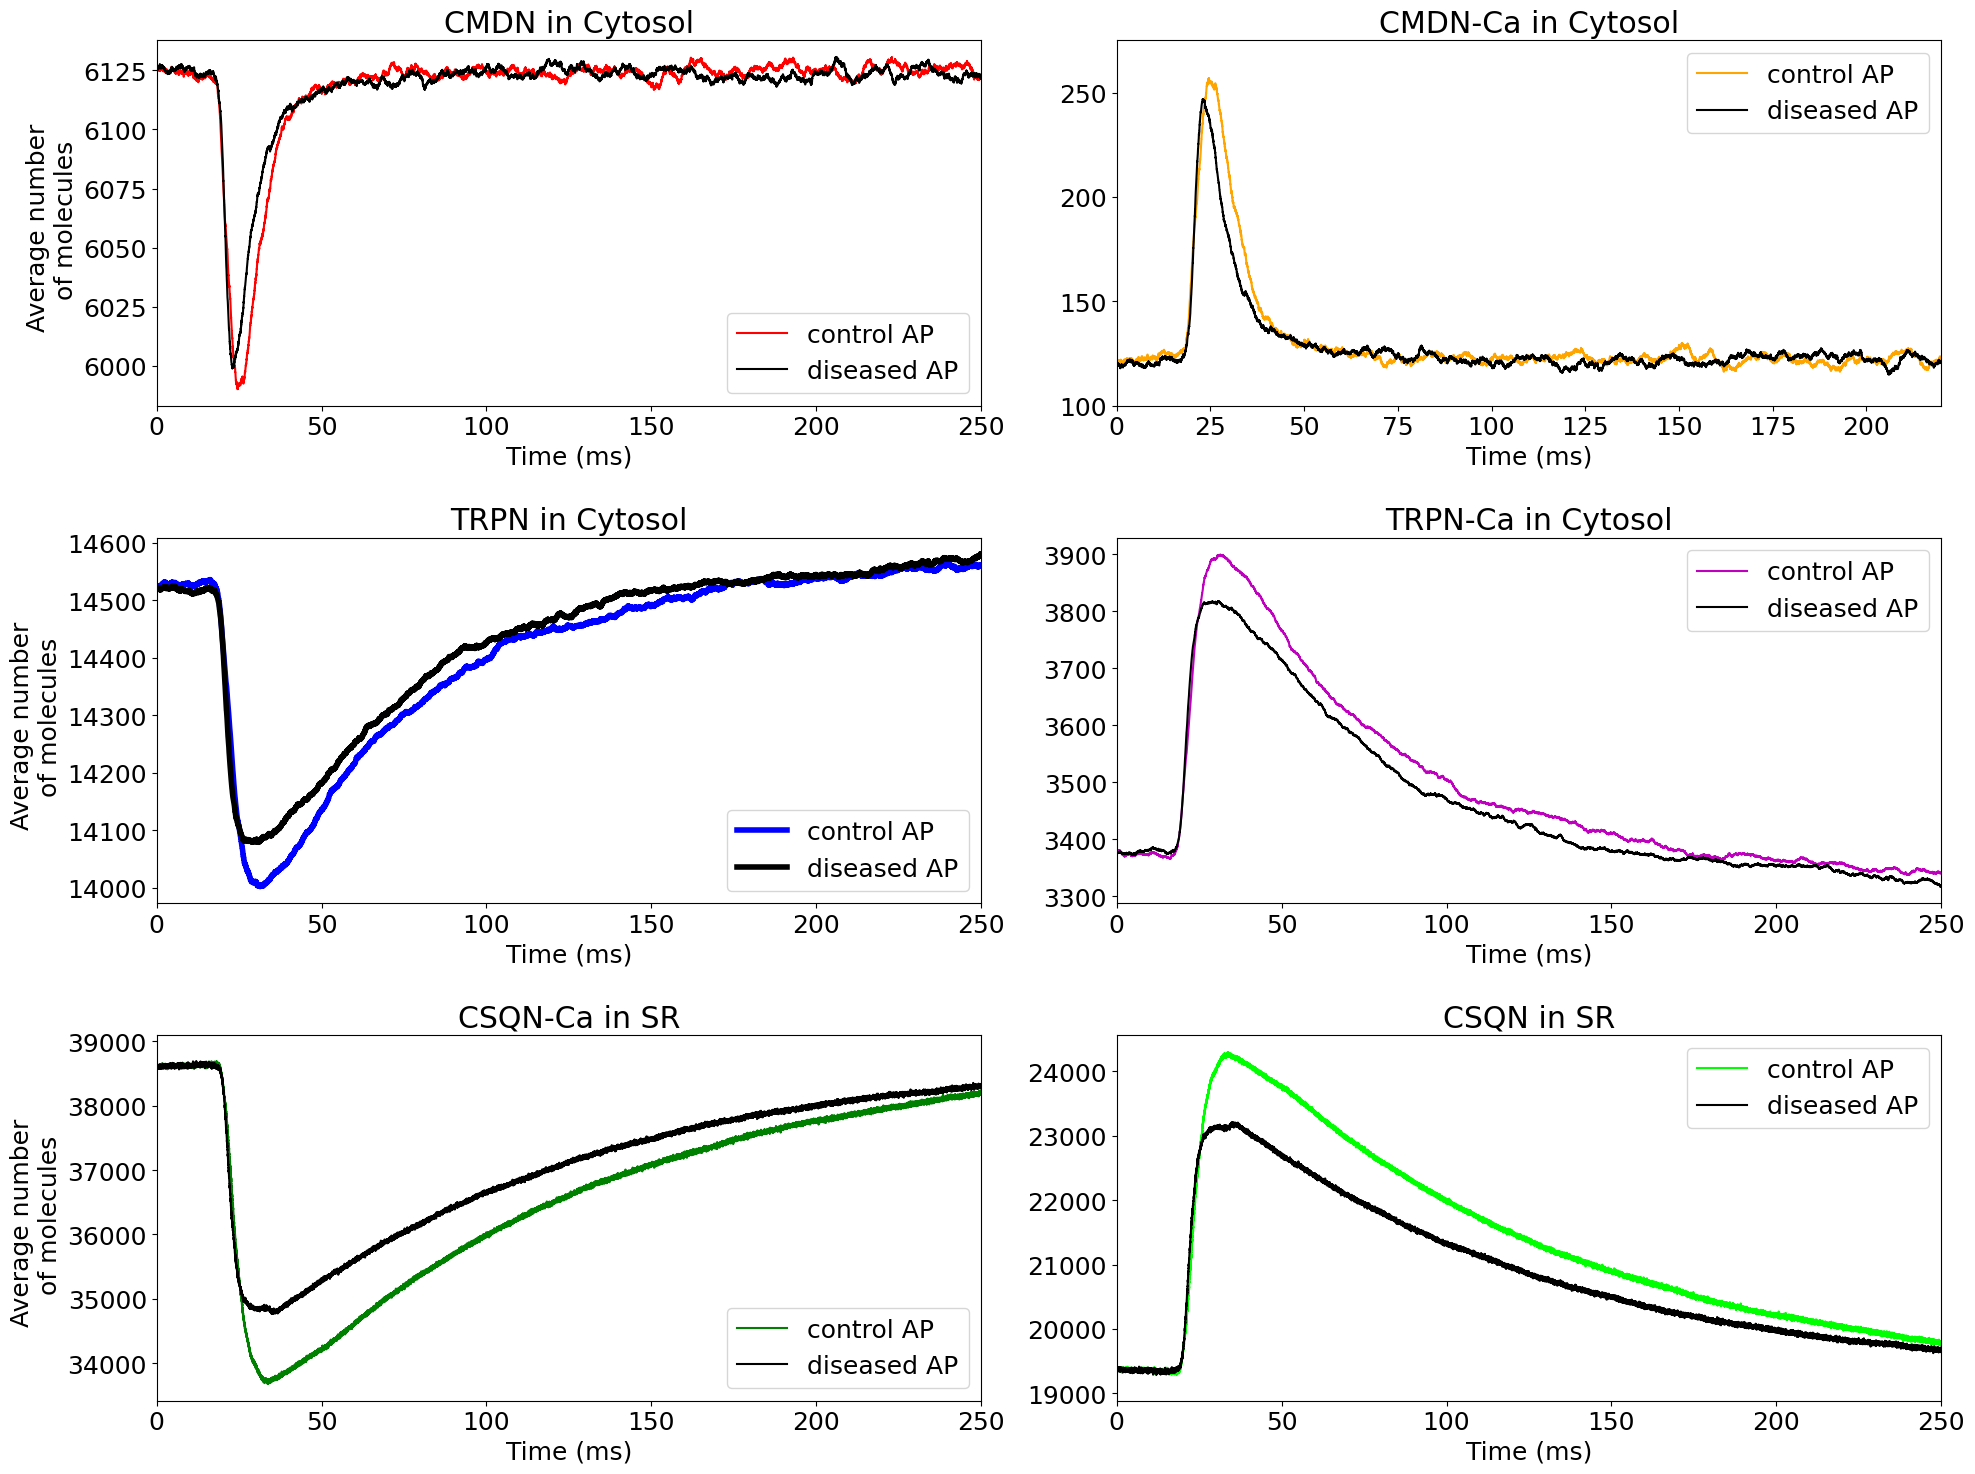

9

In [37]:


# Function to load data sets for each simulation case
def load_simulation_data(simulation_cases, states):
    data = {}
    for sim in simulation_cases:
        data[sim] = {}
        for state in states:
            data[sim][state] = load_data_set(sim=sim, rel='', f=state, scale='', settings=saftenku_settings)
    return data

# Define simulation cases and states
simulation_cases = [simA, simB]
states = ['cmd', 'cmdca', 'trp', 'trpca', 'csq', 'csqca']
control_label='control AP'
diseased_label='diseased AP'


def truncate_arrays(t, y):
    min_length = min(len(t), len(y))
    return t[:min_length], y[:min_length]



# Load the data
data_sets = load_simulation_data(simulation_cases, states)

# Time axis - assuming all datasets have the same time axis
t = data_sets[simA]['cmd']['x'] * 1000  # Adjust 'x' based on your data structure

# Creating subplots
fig, ((ax1, ax2), (ax3, ax4), (ax6, ax5 )) = plt.subplots(ncols=2, nrows=3, figsize=(20, 15))
#fig.tight_layout(h_pad=2)

# Plotting data for each subplot
# ax1 - CMDN
ax1.plot(t, data_sets[simA]['cmd']['y'], 'r', label=control_label)
#ax1.plot(t, data_sets[simB]['cmd']['y'], 'k', label=diseased_label)
t_truncated, y_truncated = truncate_arrays(t, data_sets[simB]['cmd']['y'])
ax1.plot(t_truncated, y_truncated, 'k', label=diseased_label)
ax1.set_xlabel('Time (ms)')
ax1.set_xlim([0, 250])
ax1.legend(loc='lower right')
ax1.set_ylabel('Average number \n of molecules')
ax1.set_title('CMDN in Cytosol')

# ax2 - CMDN-Ca
ax2.set_yticks([100, 150, 200, 250, 300, 350, 400])
ax2.plot(t, data_sets[simA]['cmdca']['y'], 'orange', label=control_label)
#ax2.plot(t, data_sets[simB]['cmdca']['y'], 'black', label=diseased_label)
t_truncated, y_truncated = truncate_arrays(t, data_sets[simB]['cmdca']['y'])
ax2.plot(t_truncated, y_truncated, 'black', label=diseased_label)
ax2.set_xlabel('Time (ms)')
ax2.set_ylim([100, 275])
ax2.set_xlim([0, 220])
ax2.legend()
#ax2.set_ylabel('Average number \n of ions')
ax2.set_title('CMDN-Ca in Cytosol')

# ax3 - TRPN
ax3.plot(t, data_sets[simA]['trp']['y'], 'b', label=control_label, linewidth=4)
#ax3.plot(t, data_sets[simB]['trp']['y'], 'k', label=diseased_label, linewidth=4)
t_truncated, y_truncated = truncate_arrays(t, data_sets[simB]['trp']['y'])
ax3.plot(t_truncated, y_truncated, 'k', label=diseased_label, linewidth=4)
ax3.set_xlabel('Time (ms)')
ax3.set_xlim([0, 250])
ax3.legend(loc='lower right')
ax3.set_ylabel('Average number \n of molecules')
ax3.set_title('TRPN in Cytosol')

# ax4 - TRPN-Ca
ax4.plot(t, data_sets[simA]['trpca']['y'], 'm', label=control_label)
#ax4.plot(t, data_sets[simB]['trpca']['y'], 'k', label=diseased_label)
t_truncated, y_truncated = truncate_arrays(t, data_sets[simB]['trpca']['y'])
ax4.plot(t_truncated, y_truncated, 'k', label=diseased_label)
ax4.set_xlabel('Time (ms)')
ax4.set_xlim([0, 250])
ax4.legend()
#ax4.set_ylim([38475, 38575])  # Set specific y-axis limits for this plot
#ax4.set_ylabel('Average number \n of molecules')
ax4.set_title('TRPN-Ca in Cytosol')

# ax5 - CSQN
ax5.plot(t, data_sets[simA]['csq']['y'], 'lime', label=control_label)
#ax5.plot(t, data_sets[simB]['csq']['y'], 'k', label=diseased_label)
t_truncated, y_truncated = truncate_arrays(t, data_sets[simB]['csq']['y'])
ax5.plot(t_truncated, y_truncated, 'k', label=diseased_label)
ax5.set_xlabel('Time (ms)')
ax5.set_xlim([0, 250])
ax5.legend()
ax5.set_title('CSQN in SR')

# ax6 - CSQN-Ca
ax6.plot(t, data_sets[simA]['csqca']['y'], 'g', label=control_label)
#ax6.plot(t, data_sets[simB]['csqca']['y'], 'k', label=diseased_label)
t_truncated, y_truncated = truncate_arrays(t, data_sets[simB]['csqca']['y'])
ax6.plot(t_truncated, y_truncated, 'k', label=diseased_label)
ax6.set_xlabel('Time (ms)')
ax6.set_xlim([0, 250])
ax6.legend(loc='lower right')
ax6.set_ylabel('Average number \n of molecules')
ax6.set_title('CSQN-Ca in SR')




#format_axis_with_comma(ax1)
#format_axis_with_comma(ax3)
#format_axis_with_comma(ax4)
#format_axis_with_comma(ax5)
#format_axis_with_comma(ax6)
plt.tight_layout(pad=0.9, w_pad=0.9, h_pad=1.5)
plt.savefig(plot_prefix+'FigSX_BuffersAP.png', dpi=300)
plt.savefig(plot_prefix+'FigSX_BuffersAP.pdf', dpi=300)
plt.show()
gc.collect()

# Figure 10a Concentration of Calcium in Dyadic cleft, altering TT geometry and APs

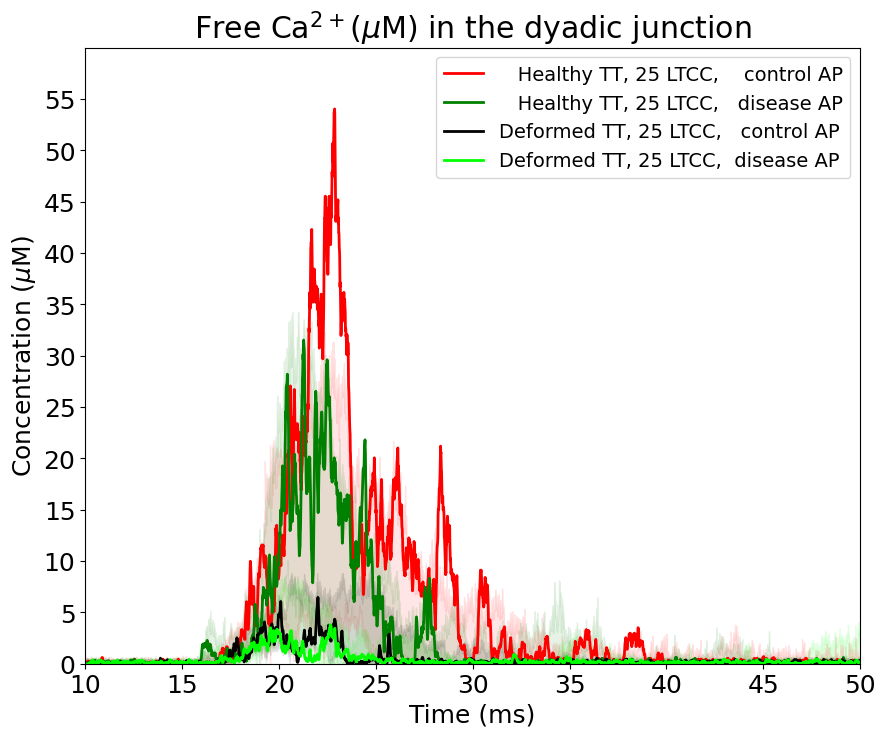

6492

In [62]:
seed_n=7


def load_data(file_path):
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def normalize_data_to_micromolarity(data, volume_in_cubic_micrometers):
    volume_in_liters = volume_in_cubic_micrometers * 1e-15
    micromolarity_data = (data / (volume_in_liters * 6.022e23)) * 1e6
    return micromolarity_data

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color):
    volume = healthy_cleft_volume if 'healthy' in condition_folder else deformed_cleft_volume
    
    individual_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.jDyad_sample_volume.dat'
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/Ca_cyt.jDyad_sample_volume.avg_stddev.dat'

    individual_data = load_data(individual_file_path)
    time_in_ms = individual_data[0] * 1000
    individual_micromolarity = normalize_data_to_micromolarity(individual_data[1], volume)
    
    window_size = 8
    filtered_individual_micromolarity = moving_average(individual_micromolarity, window_size)
    filtered_time_in_ms = moving_average(time_in_ms, window_size)

    plt.plot(filtered_time_in_ms, filtered_individual_micromolarity, label=label, color=color, linewidth=2)

    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000
    avg_micromolarity = normalize_data_to_micromolarity(avg_data[1], volume)
    stddev_micromolarity = normalize_data_to_micromolarity(avg_data[2], volume)
    
    plt.fill_between(avg_time_in_ms, avg_micromolarity - stddev_micromolarity, avg_micromolarity + stddev_micromolarity, color=shade_color, alpha=0.1)

base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot
#seed = 9 # or any other seed you want to analyze
seed = seed_n
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [

#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','green',get_lighter_color('green')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',' Healthy TT, 50 LTCC,              control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',' Healthy TT, 25 LTCC,              control AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',' Healthy TT, 10 LTCC,              control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files','   Healthy TT, 25 LTCC,    control AP','red',get_lighter_color('red')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files','   Healthy TT, 25 LTCC,   disease AP','green',get_lighter_color('green')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files','Deformed TT, 25 LTCC,   control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files','Deformed TT, 25 LTCC,  disease AP','lime',get_lighter_color('lime')),

]

for condition_folder, label, color, shade_color in conditions:
    plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.ylabel('Concentration ($\mu$M)')
# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(10, 50)
plt.ylim(0, 60)
plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, ])
plt.title('Free Ca$^{2+}$($\mu$M) in the dyadic junction')
plt.legend(loc='upper right', prop={'size': 14})
plt.savefig(plot_prefix+'Fig10a_ConcCa-spread.png', dpi=300)
plt.savefig(plot_prefix+'Fig10a_ConcCa-spread.pdf', dpi=300)
plt.legend(loc='upper right', prop={'size': 14})
plt.show()
gc.collect()

# Figure 10b All calcium-bound and calcium free species

<Figure size 1000x800 with 0 Axes>

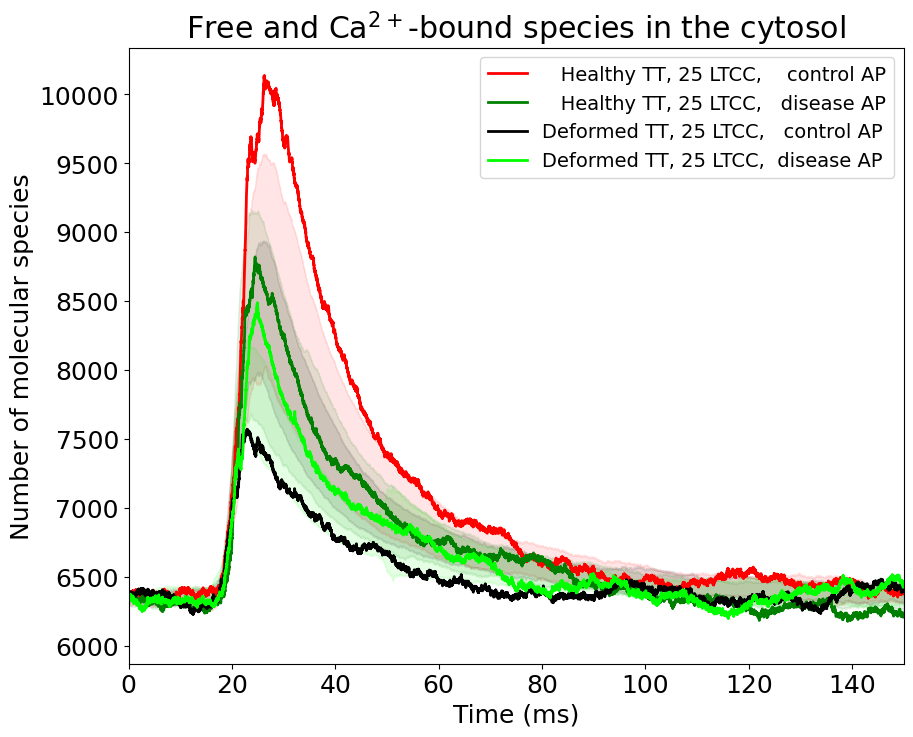

7515

In [64]:
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.2):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_paths = [
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X1.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/ATP_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/CMDN_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/FLO4_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/TRPN_Ca.World.dat',
    ]
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/Ca_cyt_species.avg_stddev.dat'

    # Load the individual data
    individual_data_frames = [load_data(path) for path in individual_file_paths]

    # Check if the time columns in both data sets are identical
    if individual_data_frames[0][0].equals(individual_data_frames[1][0]):
        # Sum the counts of molecules
        #summed_mols = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1]
        summed_mols = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1] + individual_data_frames[4][1] + individual_data_frames[5][1] + individual_data_frames[6][1] + individual_data_frames[7][1]
        # Convert time from seconds to milliseconds
        time_in_ms = individual_data_frames[0][0] * 1000
        # Plot individual data
        plt.plot(time_in_ms, summed_mols, label=label, color=color, linewidth=2)
    else:
        print(f"Time points are not aligned for {label}.")

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.1)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Plotting setup
plt.figure(figsize=(10, 8))

# Seeds to plot
#seed = 9 # or any other seed you want to analyze
seed = 7
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [

#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','green',get_lighter_color('green')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',' Healthy TT, 50 LTCC,              control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',' Healthy TT, 25 LTCC,              control AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',' Healthy TT, 10 LTCC,              control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files','   Healthy TT, 25 LTCC,    control AP','red',get_lighter_color('red')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files','   Healthy TT, 25 LTCC,   disease AP','green',get_lighter_color('green')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files','Deformed TT, 25 LTCC,   control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files','Deformed TT, 25 LTCC,  disease AP','lime',get_lighter_color('lime')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_50-RyR_off_files', 'System with 50 LTCC, no RyR, control AP', 'green', get_lighter_color('green')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_40-RyR_off_files', 'System with 40 LTCC, no RyR, control AP', 'blue', get_lighter_color('blue')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_25-RyR_off_files', '   Healthy TT, 25 LTCC,    control AP    no RyR', 'blue', get_lighter_color('blue')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_10-RyR_off_files', 'System with 10 LTCC, no RyR, control AP', 'magenta', get_lighter_color('magenta'))

]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(0,  150)
#plt.ylim(6000, 10000)
plt.ylabel('Number of molecular species')
plt.title('Free and Ca$^{2+}$-bound species in the cytosol')
plt.legend(loc='upper right', prop={'size': 14})
plt.savefig(plot_prefix+'Fig10b_AllCaMols.png', dpi=300)
plt.savefig(plot_prefix+'Fig10b_AllCaMols.pdf', dpi=300)
plt.show()
gc.collect()

# Figure 10c Number of Voltage activated LTCC, altering TT geometry and APs

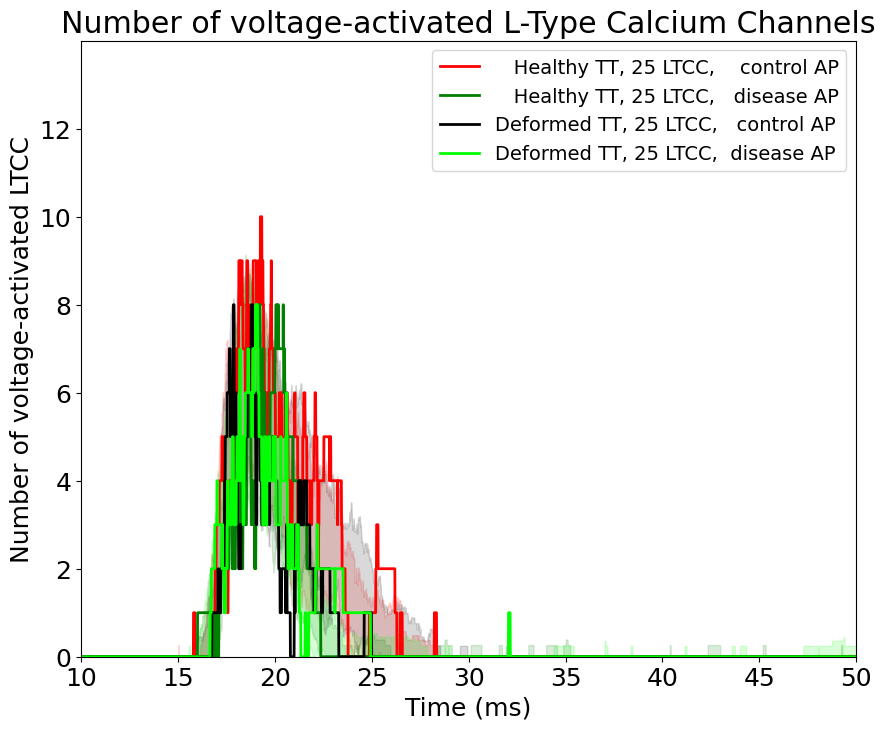

3935

In [30]:
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.5):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_N6.World.dat'
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/VoltActLTCC.avg_stddev.dat'

    # Load the individual data
    individual_data_frame = load_data(individual_file_path)

    # Sum the counts of open LTCC
    summed_ltcc = individual_data_frame[1]
    # Convert time from seconds to milliseconds
    time_in_ms = individual_data_frame[0] * 1000
    # Plot individual data
    plt.plot(time_in_ms, summed_ltcc, label=label, color=color, linewidth=2)

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]


    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.15)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot
#seed = 9 # or any other seed you want to analyze
seed = 7
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [

#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','green',get_lighter_color('green')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',' Healthy TT, 50 LTCC,              control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',' Healthy TT, 25 LTCC,              control AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',' Healthy TT, 10 LTCC,              control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files','   Healthy TT, 25 LTCC,    control AP','red',get_lighter_color('red')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files','   Healthy TT, 25 LTCC,   disease AP','green',get_lighter_color('green')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files','Deformed TT, 25 LTCC,   control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files','Deformed TT, 25 LTCC,  disease AP','lime',get_lighter_color('lime')),

]


# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(10, 50)
#plt.ylim(0, 20)
plt.ylim(0, 14)
#plt.xticks([15, 20, 25, 30])
#plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.yticks([0, 2, 4, 6, 8, 10, 12 ])
plt.legend(loc='upper right', prop={'size': 14})
plt.ylabel('Number of voltage-activated LTCC')
plt.title(r'Number of voltage-activated L-Type Calcium Channels')
plt.savefig(plot_prefix+'Fig10c_VoltActLTCC-TT-AP.png', dpi=300)
plt.savefig(plot_prefix+'Fig10c_VoltActTCC-TT-AP.pdf', dpi=300)
plt.show()
gc.collect()

# Figure 10d Number of open RyR, altering TT geometry and APs

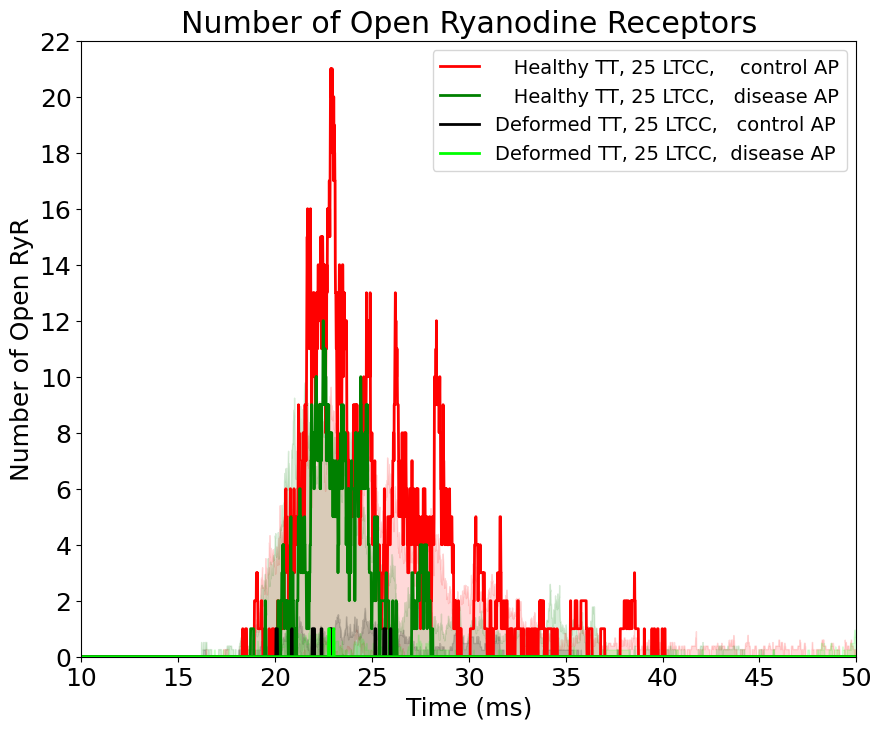

4447

In [31]:
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.5):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_paths = [
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO1_L.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO2_L.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO3_L.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO1_H1.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO2_H1.World.dat',
    ]
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/OpenRyR.avg_stddev.dat'

    # Load the individual data
    individual_data_frames = [load_data(path) for path in individual_file_paths]

    # Check if the time columns in both data sets are identical
    if individual_data_frames[0][0].equals(individual_data_frames[1][0]):
        # Sum the counts of open LTCC
        summed_ltcc = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1] + individual_data_frames[4][1] 
        # Convert time from seconds to milliseconds
        time_in_ms = individual_data_frames[0][0] * 1000
        # Plot individual data
        plt.plot(time_in_ms, summed_ltcc, label=label, color=color, linewidth=2)
    else:
        print(f"Time points are not aligned for {label}.")

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.15)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot
#seed = 9 # or any other seed you want to analyze
seed = 7
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [

#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','green',get_lighter_color('green')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',' Healthy TT, 50 LTCC,              control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',' Healthy TT, 25 LTCC,              control AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',' Healthy TT, 10 LTCC,              control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files','   Healthy TT, 25 LTCC,    control AP','red',get_lighter_color('red')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files','   Healthy TT, 25 LTCC,   disease AP','green',get_lighter_color('green')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files','Deformed TT, 25 LTCC,   control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files','Deformed TT, 25 LTCC,  disease AP','lime',get_lighter_color('lime')),

]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(10, 50)
plt.ylim(0, 22)
#plt.ylim(0, 16)
#plt.xticks([15, 20, 25, 30])
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
#plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
plt.legend(loc='upper right', prop={'size': 14})
plt.ylabel('Number of Open RyR')
plt.title(r'Number of Open Ryanodine Receptors')
plt.savefig(plot_prefix+'Fig10d_openRyR-TT-AP.png', dpi=300)
plt.savefig(plot_prefix+'Fig10d_openRyR-TT-AP.pdf', dpi=300)
plt.show()
gc.collect()

# Fig 10e Average LTCC flux rate across systems

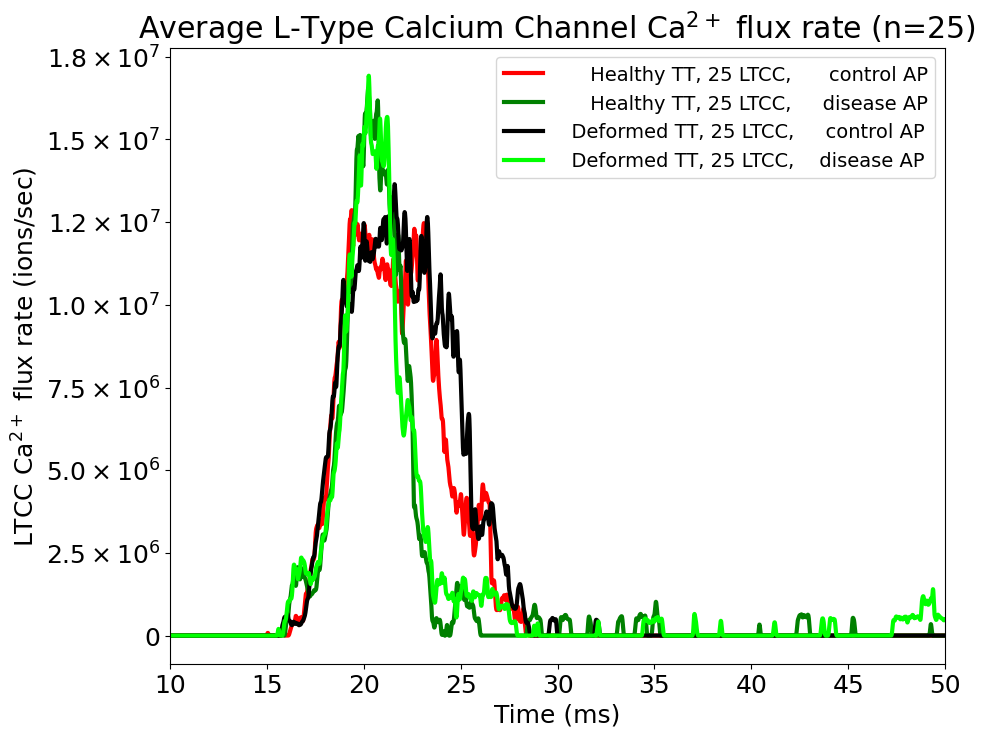

In [32]:
dt=1e-6
nyquist_freq=0.5/dt
filter_freq=100000 # Hz

Wn= filter_freq/nyquist_freq
(filter_b, filter_a) = signal.iirfilter(4,Wn,None,None,'lowpass',0,'bessel','ba') #4 pole bessel filter
(filter_d, filter_c) = signal.iirfilter(4,Wn,None,None,'lowpass',0,'bessel','ba') #4 pole bessel filter

def forward_diff_series(efflux_set, influx_set, Filter=True, Max=True):
    #set forward difference equal to Efflux - Influx for RyR
    diff=np.subtract(efflux_set['y'],influx_set['y'])
    #take forward difference
    f_diff=np.diff(diff)
    #get rate of forward difference
    diff_rate=np.divide(f_diff,dt)
    #filter the data
    filt_data=signal.filtfilt(filter_d, filter_c, diff_rate)
    #get the max of the filtered data
    max_filt=np.max(filt_data)
    if Filter:
        return(filt_data)
    if Max:
        return(max_filt)
    return diff_rate
    
custom_labels = {
    'L25alt5':   '     Healthy TT, 25 LTCC,      control AP',
    'L25dalt5': '     Healthy TT, 25 LTCC,     disease AP',
    'L25Dalt5':  '  Deformed TT, 25 LTCC,     control AP',
    'L25Ddalt5': '  Deformed TT, 25 LTCC,    disease AP'
}

def format_ticks(x, pos):
    return '{:1.1e}'.format(x)

def scientific_format(x, pos):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10 ** exponent)
    return r'${:.1f} \times 10^{{{}}}$'.format(coeff, exponent)

plt.figure(figsize=(10,8))
#plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.gca().yaxis.set_major_formatter(FuncFormatter(scientific_format))
plotcolors=iter(cycle(['r','g','k','lime']))
#define scales
scale1='0.05'
#sims = ['LTCC_10', 'LTCC_15', 'LTCC_20', 'LTCC_25','LTCC_30', 'LTCC_40', 'LTCC_50']
sims = ['L25alt5','L25dalt5','L25Dalt5','L25Ddalt5',]

for sim in sims:
    efflux_set = load_data_set(
        sim=sim, #for loop iterates along array of scales
        rel='',
        f='iLTCC',
        scale=scale1,
        settings=saftenku_settings
    )
    influx_set = load_data_set(
        sim=sim,
        rel='',
        f='eLTCC',     
        scale=scale1,
        settings=saftenku_settings
    )
    f_diff_series_filt = forward_diff_series(
        efflux_set=efflux_set,
        influx_set=influx_set,
        Filter=True  #False to use non-filtered series
    )
    
    t = efflux_set['x'] * 1000
    time = t[:-1]

    plt.plot(
        time,
        f_diff_series_filt,
        next(plotcolors), 
        label=custom_labels[sim],  # Use custom label from dictionary
        linewidth=3
    )

plt.xlabel('Time (ms)')
plt.xlim(10,50)
plt.title('Average L-Type Calcium Channel Ca$^{2+}$ flux rate (n=25)')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=3)
plt.legend(loc='upper right', prop={'size': 14}, ncol=1)
plt.ylabel(r'LTCC Ca$^{2+}$ flux rate (ions/sec)')
plt.savefig(plot_prefix+'Fig10e_LTCCflux.png', bbox_inches='tight', dpi=300)
plt.savefig(plot_prefix+'Fig10e_LTCCflux.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Fig 10f Average RyR flux rate across systems

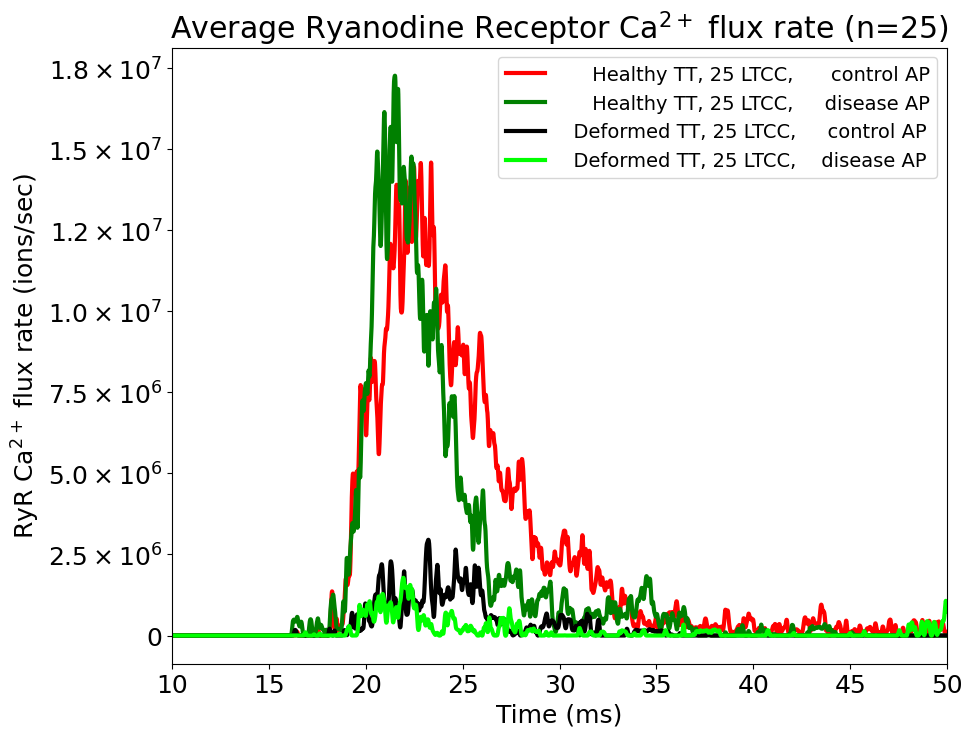

In [33]:
dt=1e-6
nyquist_freq=0.5/dt
filter_freq=100000 # Hz

Wn= filter_freq/nyquist_freq
(filter_b, filter_a) = signal.iirfilter(4,Wn,None,None,'lowpass',0,'bessel','ba') #4 pole bessel filter
(filter_d, filter_c) = signal.iirfilter(4,Wn,None,None,'lowpass',0,'bessel','ba') #4 pole bessel filter

def forward_diff_series(efflux_set, influx_set, Filter=True, Max=True):
    #set forward difference equal to Efflux - Influx for RyR
    diff=np.subtract(efflux_set['y'],influx_set['y'])
    #take forward difference
    f_diff=np.diff(diff)
    #get rate of forward difference
    diff_rate=np.divide(f_diff,dt)
    #filter the data
    filt_data=signal.filtfilt(filter_d, filter_c, diff_rate)
    #get the max of the filtered data
    max_filt=np.max(filt_data)
    if Filter:
        return(filt_data)
    if Max:
        return(max_filt)
    return diff_rate
    
custom_labels = {
    'L25alt5':   '     Healthy TT, 25 LTCC,      control AP',
    'L25dalt5': '     Healthy TT, 25 LTCC,     disease AP',
    'L25Dalt5':  '  Deformed TT, 25 LTCC,     control AP',
    'L25Ddalt5': '  Deformed TT, 25 LTCC,    disease AP'
}

def format_ticks(x, pos):
    return '{:1.1e}'.format(x)

def scientific_format(x, pos):
    if x == 0:
        return "0"
    exponent = int(np.floor(np.log10(abs(x))))
    coeff = x / (10 ** exponent)
    return r'${:.1f} \times 10^{{{}}}$'.format(coeff, exponent)

plt.figure(figsize=(10,8))
#plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ticks))
plt.gca().yaxis.set_major_formatter(FuncFormatter(scientific_format))
plotcolors=iter(cycle(['r','green','k','lime']))
#define scales
scale1='0.05'
#sims = ['LTCC_10', 'LTCC_15', 'LTCC_20', 'LTCC_25','LTCC_30', 'LTCC_40', 'LTCC_50']
sims = ['L25alt5','L25dalt5','L25Dalt5','L25Ddalt5',]

for sim in sims:
    efflux_set = load_data_set(
        sim=sim, #for loop iterates along array of scales
        rel='',
        f='eRyR',
        scale=scale1,
        settings=saftenku_settings
    )
    influx_set = load_data_set(
        sim=sim,
        rel='',
        f='iRyR',     
        scale=scale1,
        settings=saftenku_settings
    )
    f_diff_series_filt = forward_diff_series(
        efflux_set=efflux_set,
        influx_set=influx_set,
        Filter=True  #False to use non-filtered series
    )
    
    t = efflux_set['x'] * 1000
    time = t[:-1]

    plt.plot(
        time,
        f_diff_series_filt,
        next(plotcolors), 
        label=custom_labels[sim],  # Use custom label from dictionary
        linewidth=3
    )

plt.xlabel('Time (ms)')
plt.xlim(10,50)
plt.title('Average Ryanodine Receptor Ca$^{2+}$ flux rate (n=25)')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=3)
plt.legend(loc='upper right', prop={'size': 14}, ncol=1)
plt.ylabel(r'RyR Ca$^{2+}$ flux rate (ions/sec)')
plt.savefig(plot_prefix+'Fig10f_RyRflux.png', bbox_inches='tight', dpi=300)
plt.savefig(plot_prefix+'Fig10f_RyRflux.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Figure 11a Number of Voltage inactivated LTCC, altering TT geometry and APs

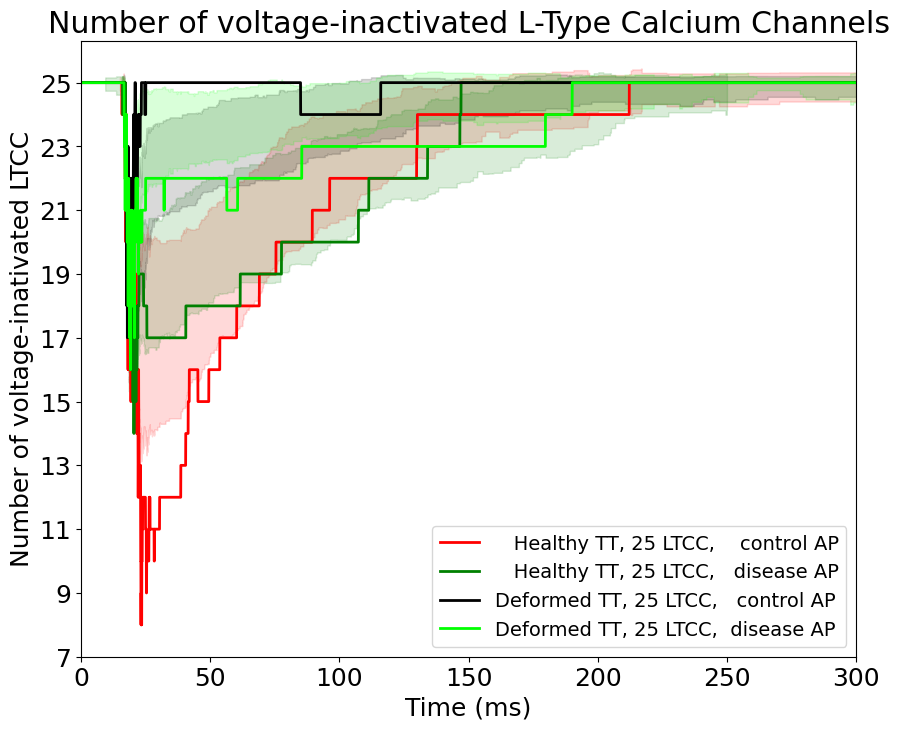

20136

In [34]:
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.5):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_paths = [
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_N1.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_N2.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_N3.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_N4.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_N5.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_N6i.World.dat',
    ]
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/VoltInactLTCC.avg_stddev.dat'

    # Load the individual data
    individual_data_frames = [load_data(path) for path in individual_file_paths]

    # Check if the time columns in both data sets are identical
    if individual_data_frames[0][0].equals(individual_data_frames[1][0]):
        # Sum the counts of open LTCC
        summed_ltcc = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1] + individual_data_frames[4][1] + individual_data_frames[5][1] 
        # Convert time from seconds to milliseconds 
        time_in_ms = individual_data_frames[0][0] * 1000
        # Plot individual data
        plt.plot(time_in_ms, summed_ltcc, label=label, color=color, linewidth=2)
    else:
        print(f"Time points are not aligned for {label}.")

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.15)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot
#seed = 9 # or any other seed you want to analyze
seed = 7
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [

#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','green',get_lighter_color('green')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',' Healthy TT, 50 LTCC,              control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',' Healthy TT, 25 LTCC,              control AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',' Healthy TT, 10 LTCC,              control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files','   Healthy TT, 25 LTCC,    control AP','red',get_lighter_color('red')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files','   Healthy TT, 25 LTCC,   disease AP','green',get_lighter_color('green')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files','Deformed TT, 25 LTCC,   control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files','Deformed TT, 25 LTCC,  disease AP','lime',get_lighter_color('lime')),

]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(0, 300)
#plt.ylim(0, 22)
#plt.xticks([15, 20, 25, 30])
plt.yticks([ 7, 9, 11, 13, 15, 17, 19, 21, 23, 25])
plt.legend(loc='lower right', prop={'size': 14})
plt.ylabel('Number of voltage-inativated LTCC')
plt.title(r'Number of voltage-inactivated L-Type Calcium Channels')
plt.savefig(plot_prefix+'Fig11a_VoltInact-TT-AP.png', dpi=300)
plt.savefig(plot_prefix+'Fig11a_VoltInact-TT-AP.pdf', dpi=300)
plt.show()
gc.collect()

# Figure 11b Number of calcium-inactivated LTCC, altering TT geometry and APs

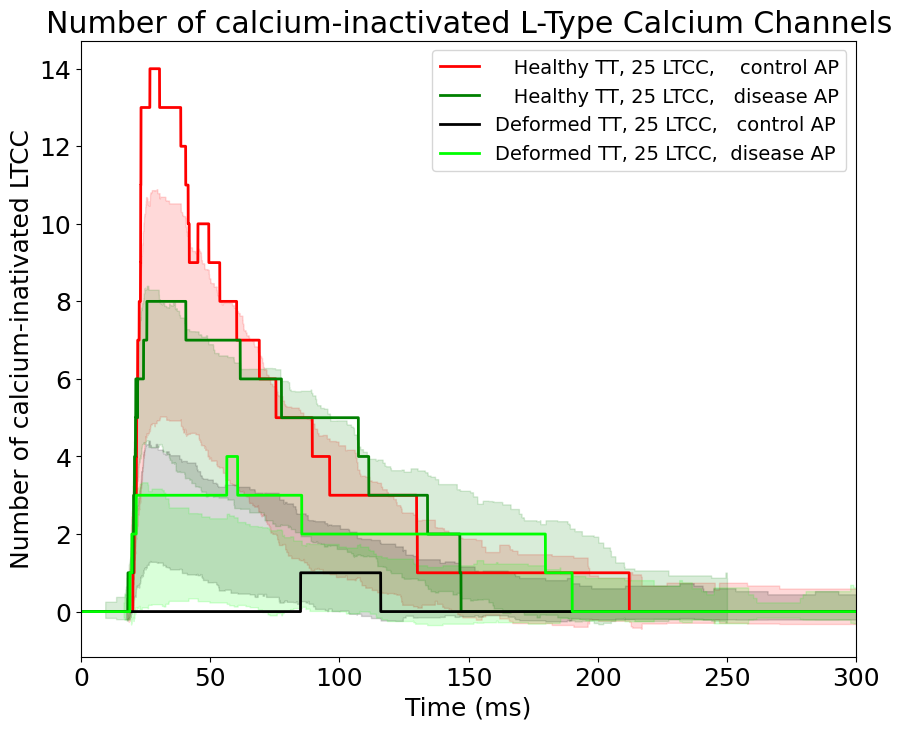

4049

In [35]:
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.5):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_paths = [
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_Ca7.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_Ca8.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_Ca9.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_Ca10.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_Ca11.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/LTCC_Ca12i.World.dat',
    ]
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/CalcInactLTCC.avg_stddev.dat'

    # Load the individual data
    individual_data_frames = [load_data(path) for path in individual_file_paths]

    # Check if the time columns in both data sets are identical
    if individual_data_frames[0][0].equals(individual_data_frames[1][0]):
        # Sum the counts of open LTCC
        summed_ltcc = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1] + individual_data_frames[4][1] + individual_data_frames[5][1] 
        # Convert time from seconds to milliseconds
        time_in_ms = individual_data_frames[0][0] * 1000
        # Plot individual data
        plt.plot(time_in_ms, summed_ltcc, label=label, color=color, linewidth=2)
    else:
        print(f"Time points are not aligned for {label}.")

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.15)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot
#seed = 9 # or any other seed you want to analyze
seed = 7
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [

#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','green',get_lighter_color('green')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',' Healthy TT, 50 LTCC,              control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',' Healthy TT, 25 LTCC,              control AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',' Healthy TT, 10 LTCC,              control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files','   Healthy TT, 25 LTCC,    control AP','red',get_lighter_color('red')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files','   Healthy TT, 25 LTCC,   disease AP','green',get_lighter_color('green')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files','Deformed TT, 25 LTCC,   control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files','Deformed TT, 25 LTCC,  disease AP','lime',get_lighter_color('lime')),

]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(0, 300)
#plt.ylim(0, 22)
#plt.xticks([15, 20, 25, 30])
#plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22])
plt.legend(loc='upper right', prop={'size': 14})
plt.ylabel('Number of calcium-inativated LTCC')
plt.title(r'Number of calcium-inactivated L-Type Calcium Channels')
plt.savefig(plot_prefix+'Fig11b_CalcInact-TT-AP.png', dpi=300)
plt.savefig(plot_prefix+'Fig11b_CalcInact-TT-AP.pdf', dpi=300)
plt.show()
gc.collect()


## Comparing counts of buffer species across simulations

In [38]:
sim1='L25alt5'
sim2='L25Ddalt5'
# List of data types
data_types = ['Cac', 'cmd', 'cmdca', 'trp', 'trpca', 'f4', 'f4c', 'CaBserca', 'CaFserca', 'csq', 'csqca', 'f5', 'f5c','Cas']
simulation_cases = [sim1, sim2]
def load_and_process_data(sim):
    # Function to load data and calculate max-min difference as an integer
    def calc_diff(data_type):
        data = load_data_set(sim=sim, rel='', f=data_type, scale='', settings=saftenku_settings)
        return int(np.max(data['y']) - np.min(data['y']))

    # Load and process data for all types
    return {dt: calc_diff(dt) for dt in data_types}

# Calculate results for each simulation case
results = {sim: load_and_process_data(sim) for sim in simulation_cases}

# Function to calculate total change as an integer
def calc_total_change(sim_results, types):
    return int(sum(sim_results[dt] for dt in types if dt in sim_results))

# Print results
for sim, sim_results in results.items():
    print(f"\nResults for {sim} simulations:")
    print("")
    for data_type, diff in sim_results.items():
        print(f"The difference of {data_type.upper()} is: {diff}")
    print("----------------------------------------------------")
    print(f"The net change in Cytosolic calcium species is: {calc_total_change(sim_results, ['cmdca', 'trpca', 'f4c', 'Cac', 'CaBserca',])}")
    print("")
    print("______________________________________________________________________")
    #print(f"The net change in Sarcoplasmic Reticulum calcium species is: {calc_total_change(sim_results, ['csqca', 'f5c', 'Cas'])}")


def load_and_process_data(sim):
    # Function to load data and calculate max-min difference
    def calc_diff(data_type):
        data = load_data_set(sim=sim, rel='', f=data_type, scale='', settings=saftenku_settings)
        return np.max(data['y']) - np.min(data['y'])

    # Load and process data for all types
    return {dt: calc_diff(dt) for dt in data_types}

# Calculate results for each simulation case
results = {sim: load_and_process_data(sim) for sim in simulation_cases}

# Function to calculate the difference between two simulation cases for each data type
def calculate_differences_between_cases(results, data_types):
    differences = {}
    for dt in data_types:
        if dt in results[sim1] and dt in results[sim2]:
            diff = results[sim1][dt] - results[sim2][dt]
            differences[dt] = int(diff)  # Convert to integer
    return differences

# Calculate differences between 'LTCC_50' and 'LTCC_50d'
case_differences = calculate_differences_between_cases(results, data_types)

print ("")
print ("Differences between simulation cases:")
print ("")
# Check if pairs are equal (e.g., 'cmd' and 'cmdca')
pairs = [('cmd', 'cmdca'), ('trp', 'trpca'), ('f4', 'f4c'), ('csq', 'csqca'), ('f5', 'f5c')]
for pair in pairs:
    if all(p in case_differences for p in pair) and case_differences[pair[0]] == case_differences[pair[1]]:
        print(f"The differences for {pair[0].upper()} and {pair[1].upper()} equal to {case_differences[pair[0]]}")




Results for L25alt5 simulations:

The difference of CAC is: 87
The difference of CMD is: 140
The difference of CMDCA is: 140
The difference of TRP is: 562
The difference of TRPCA is: 562
The difference of F4 is: 540
The difference of F4C is: 540
The difference of CABSERCA is: 1025
The difference of CAFSERCA is: 1024
The difference of CSQ is: 5155
The difference of CSQCA is: 5155
The difference of F5 is: 22
The difference of F5C is: 22
The difference of CAS is: 3421
----------------------------------------------------
The net change in Cytosolic calcium species is: 2354

______________________________________________________________________

Results for L25Ddalt5 simulations:

The difference of CAC is: 65
The difference of CMD is: 90
The difference of CMDCA is: 90
The difference of TRP is: 316
The difference of TRPCA is: 316
The difference of F4 is: 346
The difference of F4C is: 346
The difference of CABSERCA is: 605
The difference of CAFSERCA is: 605
The difference of CSQ is: 746
The 

In [39]:
# Define lists for cytosolic and SR species
cytosolic_species = ['cmdca', 'trpca', 'f4c', 'Cac', 'CaBserca']
sr_species = ['csqca', 'f5c', 'Cas']

# Existing function to load and process data
# Modified to return original data values instead of differences
def load_and_process_data(sim):
    # Function to load data
    def calc_data(data_type):
        data = load_data_set(sim=sim, rel='', f=data_type, scale='', settings=saftenku_settings)
        return data['y']  # Return the original data values

    # Load and process data for all types
    return {dt: calc_data(dt) for dt in data_types}

# Calculate results for each simulation case
results = {sim: load_and_process_data(sim) for sim in simulation_cases}

# Function to calculate total calcium in a given compartment
def calc_total_calcium(sim_results, species_list):
    return sum(np.max(sim_results[dt]) for dt in species_list if dt in sim_results)

# Function to calculate percentage contributions for a given compartment
def calc_percentage_contributions(sim_results, species_list):
    total_calcium = calc_total_calcium(sim_results, species_list)
    return {dt: (np.max(sim_results[dt]) / total_calcium) * 100 if total_calcium > 0 else 0 for dt in species_list}

# Calculating and printing the percentage contributions for each simulation case
for sim, sim_results in results.items():
    cytosolic_contributions = calc_percentage_contributions(sim_results, cytosolic_species)
    sr_contributions = calc_percentage_contributions(sim_results, sr_species)

    print(f"\nPercentage Contributions in {sim}:")
    print("\nCytosolic Species:")
    for species, percentage in cytosolic_contributions.items():
        print(f"{species}: {round(percentage, 2)}%")
    
    print("\nSR Species:")
    for species, percentage in sr_contributions.items():
        print(f"{species}: {round(percentage, 2)}%")



Percentage Contributions in L25alt5:

Cytosolic Species:
cmdca: 3.05%
trpca: 46.39%
f4c: 15.05%
Cac: 1.41%
CaBserca: 34.08%

SR Species:
csqca: 75.99%
f5c: 0.34%
Cas: 23.67%

Percentage Contributions in L25Ddalt5:

Cytosolic Species:
cmdca: 2.76%
trpca: 49.17%
f4c: 14.3%
Cac: 1.28%
CaBserca: 32.5%

SR Species:
csqca: 75.99%
f5c: 0.35%
Cas: 23.67%


In [40]:
# List of data types
data_types = ['Cac', 'cmd', 'cmdca', 'trp', 'trpca', 'f4', 'f4c', 'CaBserca', 'CaFserca', 'csq', 'csqca', 'f5', 'f5c','Cas']
simulation_cases = [sim1, sim2]
def load_and_process_data(sim):
    # Function to load data and calculate max-min difference as an integer
    def calc_diff(data_type):
        data = load_data_set(sim=sim, rel='', f=data_type, scale='', settings=saftenku_settings)
        return int(np.max(data['y']) - np.min(data['y']))

    # Load and process data for all types
    return {dt: calc_diff(dt) for dt in data_types}

# Calculate results for each simulation case
results = {sim: load_and_process_data(sim) for sim in simulation_cases}

# Function to calculate total change as an integer
def calc_total_change(sim_results, types):
    return int(sum(sim_results[dt] for dt in types if dt in sim_results))

# Print results
for sim, sim_results in results.items():
    print(f"\nResults for {sim} simulations:")
    print("")
    for data_type, diff in sim_results.items():
        print(f"The difference of {data_type.upper()} is: {diff}")
    print("----------------------------------------------------")
    print(f"The net change in Cytosolic calcium species is: {calc_total_change(sim_results, ['cmdca', 'trpca', 'f4c', 'Cac', 'CaBserca',])}")
    print("")
    print("______________________________________________________________________")
    #print(f"The net change in Sarcoplasmic Reticulum calcium species is: {calc_total_change(sim_results, ['csqca', 'f5c', 'Cas'])}")


def load_and_process_data(sim):
    # Function to load data and calculate max-min difference
    def calc_diff(data_type):
        data = load_data_set(sim=sim, rel='', f=data_type, scale='', settings=saftenku_settings)
        return np.max(data['y']) - np.min(data['y'])

    # Load and process data for all types
    return {dt: calc_diff(dt) for dt in data_types}

# Calculate results for each simulation case
results = {sim: load_and_process_data(sim) for sim in simulation_cases}

# Function to calculate the difference between two simulation cases for each data type
def calculate_differences_between_cases(results, data_types):
    differences = {}
    for dt in data_types:
        if dt in results[sim1] and dt in results[sim2]:
            diff = results[sim1][dt] - results[sim2][dt]
            differences[dt] = int(diff)  # Convert to integer
    return differences

# Calculate differences between 'LTCC_50' and 'LTCC_50d'
case_differences = calculate_differences_between_cases(results, data_types)

print ("")
print ("Differences between simulation cases:")
print ("")
# Check if pairs are equal (e.g., 'cmd' and 'cmdca')
pairs = [('cmd', 'cmdca'), ('trp', 'trpca'), ('f4', 'f4c'), ('csq', 'csqca'), ('f5', 'f5c')]
for pair in pairs:
    if all(p in case_differences for p in pair) and case_differences[pair[0]] == case_differences[pair[1]]:
        print(f"The differences for {pair[0].upper()} and {pair[1].upper()} equal to {case_differences[pair[0]]}")




Results for L25alt5 simulations:

The difference of CAC is: 87
The difference of CMD is: 140
The difference of CMDCA is: 140
The difference of TRP is: 562
The difference of TRPCA is: 562
The difference of F4 is: 540
The difference of F4C is: 540
The difference of CABSERCA is: 1025
The difference of CAFSERCA is: 1024
The difference of CSQ is: 5155
The difference of CSQCA is: 5155
The difference of F5 is: 22
The difference of F5C is: 22
The difference of CAS is: 3421
----------------------------------------------------
The net change in Cytosolic calcium species is: 2354

______________________________________________________________________

Results for L25Ddalt5 simulations:

The difference of CAC is: 65
The difference of CMD is: 90
The difference of CMDCA is: 90
The difference of TRP is: 316
The difference of TRPCA is: 316
The difference of F4 is: 346
The difference of F4C is: 346
The difference of CABSERCA is: 605
The difference of CAFSERCA is: 605
The difference of CSQ is: 746
The 

In [41]:
# Define lists for cytosolic and SR species
cytosolic_species = ['cmdca', 'trpca', 'f4c', 'Cac', 'CaBserca']
sr_species = ['csqca', 'f5c', 'Cas']

# Existing function to load and process data
# Modified to return original data values instead of differences
def load_and_process_data(sim):
    # Function to load data
    def calc_data(data_type):
        data = load_data_set(sim=sim, rel='', f=data_type, scale='', settings=saftenku_settings)
        return data['y']  # Return the original data values

    # Load and process data for all types
    return {dt: calc_data(dt) for dt in data_types}

# Calculate results for each simulation case
results = {sim: load_and_process_data(sim) for sim in simulation_cases}

# Function to calculate total calcium in a given compartment
def calc_total_calcium(sim_results, species_list):
    return sum(np.max(sim_results[dt]) for dt in species_list if dt in sim_results)

# Function to calculate percentage contributions for a given compartment
def calc_percentage_contributions(sim_results, species_list):
    total_calcium = calc_total_calcium(sim_results, species_list)
    return {dt: (np.max(sim_results[dt]) / total_calcium) * 100 if total_calcium > 0 else 0 for dt in species_list}

# Calculating and printing the percentage contributions for each simulation case
for sim, sim_results in results.items():
    cytosolic_contributions = calc_percentage_contributions(sim_results, cytosolic_species)
    sr_contributions = calc_percentage_contributions(sim_results, sr_species)

    print(f"\nPercentage Contributions in {sim}:")
    print("\nCytosolic Species:")
    for species, percentage in cytosolic_contributions.items():
        print(f"{species}: {round(percentage, 2)}%")
    
    print("\nSR Species:")
    for species, percentage in sr_contributions.items():
        print(f"{species}: {round(percentage, 2)}%")



Percentage Contributions in L25alt5:

Cytosolic Species:
cmdca: 3.05%
trpca: 46.39%
f4c: 15.05%
Cac: 1.41%
CaBserca: 34.08%

SR Species:
csqca: 75.99%
f5c: 0.34%
Cas: 23.67%

Percentage Contributions in L25Ddalt5:

Cytosolic Species:
cmdca: 2.76%
trpca: 49.17%
f4c: 14.3%
Cac: 1.28%
CaBserca: 32.5%

SR Species:
csqca: 75.99%
f5c: 0.35%
Cas: 23.67%


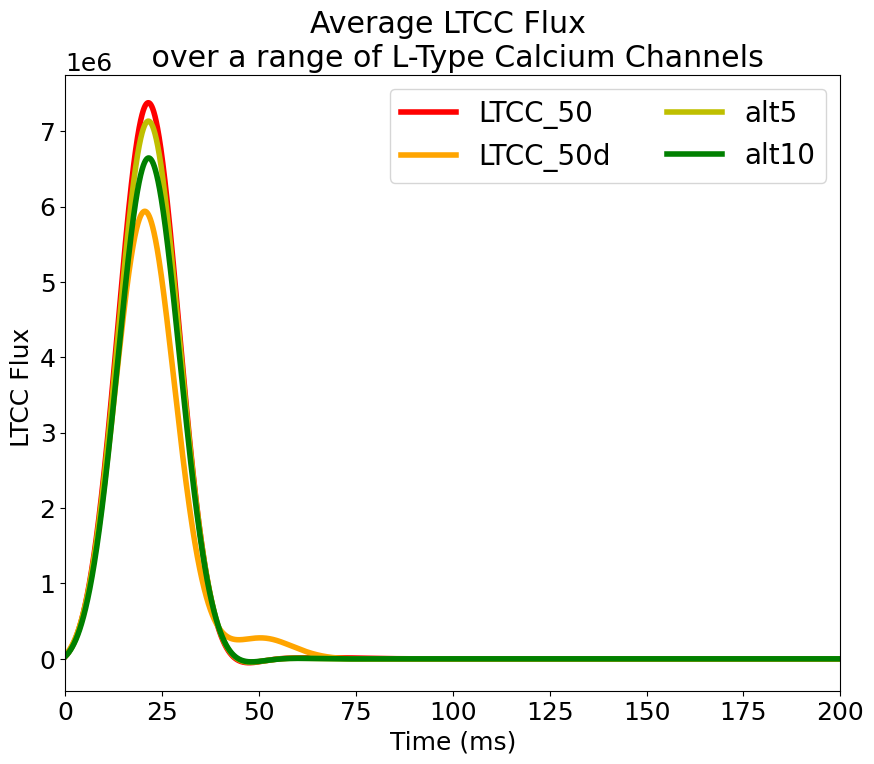

3946

In [42]:
dt=1e-6
nyquist_freq=0.5/dt
filter_freq=400.0 # Hz

Wn= filter_freq/nyquist_freq
(filter_b, filter_a) = signal.iirfilter(4,Wn,None,None,'lowpass',0,'bessel','ba') #4 pole bessel filter
(filter_d, filter_c) = signal.iirfilter(4,Wn,None,None,'lowpass',0,'bessel','ba') #4 pole bessel filter

def forward_diff_series(efflux_set, influx_set, Filter=True, Max=True):
    #set forward difference equal to Influx - Efflux for LTXX
    diff=np.subtract(influx_set['y'],efflux_set['y'])
    #take forward difference
    f_diff=np.diff(diff)
    #get rate of forward difference
    diff_rate=np.divide(f_diff,dt)
    #filter the data
    filt_data=signal.filtfilt(filter_d, filter_c, diff_rate)
    #get the max of the filtered data
    max_filt=np.max(filt_data)
    if Filter:
        return(filt_data)
    if Max:
        return(max_filt)
    return diff_rate


plt.figure(figsize=(10,8))
plotcolors=iter(cycle(['r','orange','y','g','b','m','k']))
#define scales
scale1='0.05'
#sims = ['LTCC_10', 'LTCC_15', 'LTCC_20', 'LTCC_25','LTCC_30', 'LTCC_40', 'LTCC_50']
sims = ['LTCC_50','LTCC_50d','alt5','alt10' ]
for sim in sims:
    efflux_set = load_data_set(
        sim=sim, #for loop iterates along array of scales
        rel='',
        f='eLTCC',
        scale=scale1,
        settings=saftenku_settings
    )
    influx_set = load_data_set(
        sim=sim,
        rel='',
        f='iLTCC',     
        scale=scale1,
        settings=saftenku_settings
    )
    f_diff_series_filt = forward_diff_series(
        efflux_set=efflux_set,
        influx_set=influx_set,
        Filter=True  #False to use non-filtered series
    )
    
    t = efflux_set['x'] * 1000
    time = t[:-1]

    plt.plot(
        time,
        f_diff_series_filt,
        next(plotcolors), 
        label=(sim),
        linewidth=4
    )

plt.xlabel('Time (ms)')
plt.xlim(0,200)
plt.title('Average LTCC Flux \n over a range of L-Type Calcium Channels')
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  shadow=True, ncol=3)
plt.legend(loc='upper right', prop={'size': 20}, ncol=2)
plt.ylabel(r'LTCC Flux ')
plt.savefig(plot_prefix+'dLTCC_RyRflux.png', bbox_inches='tight', dpi=300)
plt.savefig(plot_prefix+'dLTCC_RyRflux.pdf', bbox_inches='tight', dpi=300)
plt.show()
gc.collect()

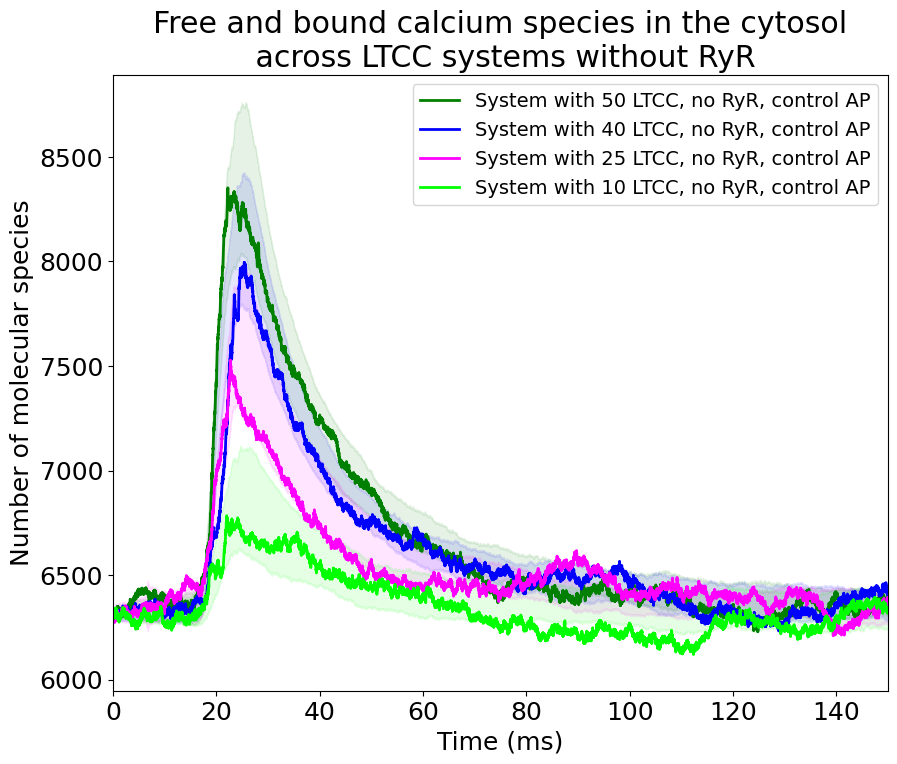

4050

In [43]:

def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.2):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_paths = [
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X1.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/ATP_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/CMDN_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/FLO4_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/TRPN_Ca.World.dat',
    ]
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/Ca_cyt_species.avg_stddev.dat'

    # Load the individual data
    individual_data_frames = [load_data(path) for path in individual_file_paths]

    # Check if the time columns in both data sets are identical
    if individual_data_frames[0][0].equals(individual_data_frames[1][0]):
        # Sum the counts of molecules
        #summed_mols = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1]
        summed_mols = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1] + individual_data_frames[4][1] + individual_data_frames[5][1] + individual_data_frames[6][1] + individual_data_frames[7][1]
        # Convert time from seconds to milliseconds
        time_in_ms = individual_data_frames[0][0] * 1000
        # Plot individual data
        plt.plot(time_in_ms, summed_mols, label=label, color=color, linewidth=2)
    else:
        print(f"Time points are not aligned for {label}.")

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.1)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot
seed = 15 # or any other seed you want to analyze
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [
    ('Hirakis_CRU_RyR-Saftenku-LTCC_50-RyR_off_files', 'System with 50 LTCC, no RyR, control AP', 'green', get_lighter_color('green')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_40-RyR_off_files', 'System with 40 LTCC, no RyR, control AP', 'blue', get_lighter_color('blue')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_25-RyR_off_files', 'System with 25 LTCC, no RyR, control AP', 'magenta', get_lighter_color('magenta')),
    ('Hirakis_CRU_RyR-Saftenku-LTCC_10-RyR_off_files', 'System with 10 LTCC, no RyR, control AP', 'lime', get_lighter_color('lime'))
]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(0,  150)
#plt.ylim(6000, 11500)
plt.ylabel('Number of molecular species')
plt.title('Free and bound calcium species in the cytosol'
          '\n across LTCC systems without RyR')
plt.legend(loc='upper right', prop={'size': 14})
plt.savefig(plot_prefix+'Fig8d_AllCaMols.png', dpi=300)
plt.savefig(plot_prefix+'Fig8d_AllCaMols.pdf', dpi=300)
plt.show()
gc.collect()

<Figure size 1000x800 with 0 Axes>

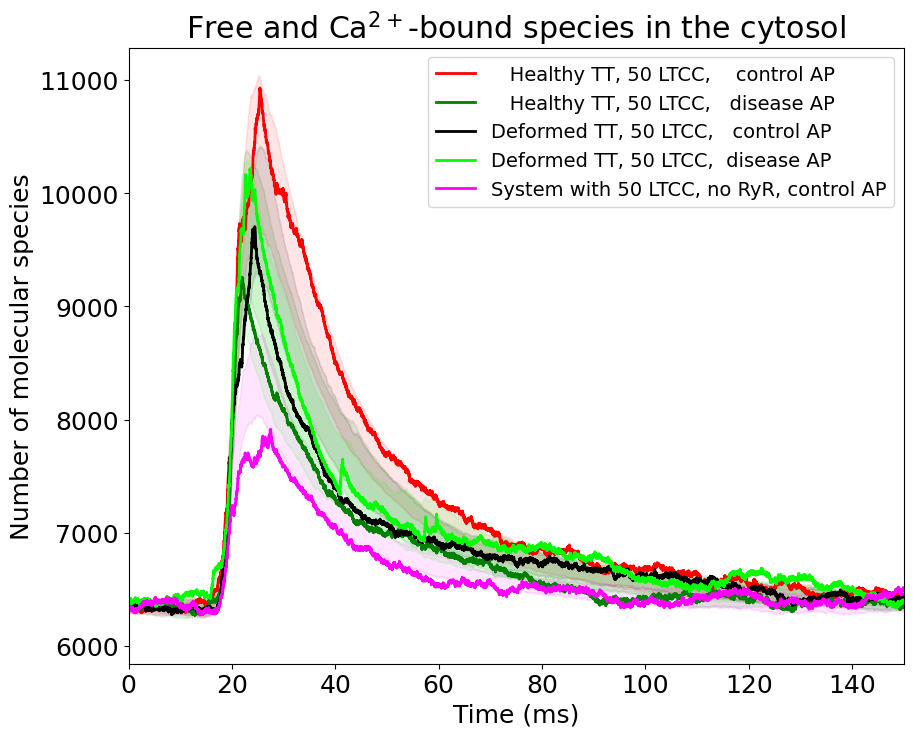

5938

In [65]:
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.2):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_paths = [
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X1.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/ATP_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/CMDN_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/FLO4_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/TRPN_Ca.World.dat',
    ]
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/Ca_cyt_species.avg_stddev.dat'

    # Load the individual data
    individual_data_frames = [load_data(path) for path in individual_file_paths]

    # Check if the time columns in both data sets are identical
    if individual_data_frames[0][0].equals(individual_data_frames[1][0]):
        # Sum the counts of molecules
        #summed_mols = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1]
        summed_mols = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1] + individual_data_frames[4][1] + individual_data_frames[5][1] + individual_data_frames[6][1] + individual_data_frames[7][1]
        # Convert time from seconds to milliseconds
        time_in_ms = individual_data_frames[0][0] * 1000
        # Plot individual data
        plt.plot(time_in_ms, summed_mols, label=label, color=color, linewidth=2)
    else:
        print(f"Time points are not aligned for {label}.")

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.1)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Plotting setup
plt.figure(figsize=(10, 8))

# Seeds to plot
#seed = 9 # or any other seed you want to analyze
seed = 7
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [

#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','green',get_lighter_color('green')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',' Healthy TT, 50 LTCC,              control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',' Healthy TT, 25 LTCC,              control AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',' Healthy TT, 10 LTCC,              control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','green',get_lighter_color('green')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','lime',get_lighter_color('lime')),

    ('Hirakis_CRU_RyR-Saftenku-LTCC_50-RyR_off_files', 'System with 50 LTCC, no RyR, control AP', 'magenta', get_lighter_color('magenta')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_50-RyR_off_files', 'System with 50 LTCC, no RyR, control AP', 'green', get_lighter_color('green')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_40-RyR_off_files', 'System with 40 LTCC, no RyR, control AP', 'blue', get_lighter_color('blue')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_25-RyR_off_files', '   Healthy TT, 25 LTCC,    control AP    no RyR', 'blue', get_lighter_color('blue')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_10-RyR_off_files', 'System with 10 LTCC, no RyR, control AP', 'magenta', get_lighter_color('magenta'))

]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(0,  150)
#plt.ylim(6000, 10000)
plt.ylabel('Number of molecular species')
plt.title('Free and Ca$^{2+}$-bound species in the cytosol')
plt.legend(loc='upper right', prop={'size': 14})
#plt.savefig(plot_prefix+'Fig10b_AllCaMols.png', dpi=300)
#plt.savefig(plot_prefix+'Fig10b_AllCaMols.pdf', dpi=300)
plt.show()
gc.collect()

<Figure size 1000x800 with 0 Axes>

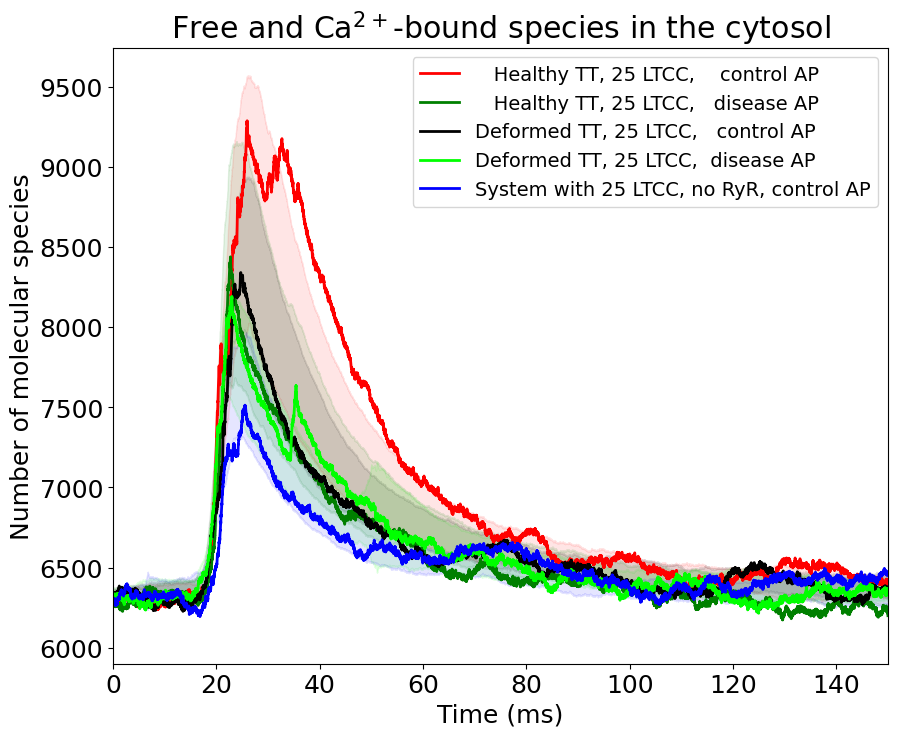

6253

In [66]:
def load_data(file_path):
    # Load the data
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def get_lighter_color(color, alpha=0.2):
    # This function can be used to get a lighter shade of the given color
    from matplotlib.colors import to_rgba
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color):
    # File paths for individual seed and average data
    individual_file_paths = [
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X1.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/ATP_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/CMDN_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/FLO4_Ca.World.dat',
        f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/TRPN_Ca.World.dat',
    ]
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/Ca_cyt_species.avg_stddev.dat'

    # Load the individual data
    individual_data_frames = [load_data(path) for path in individual_file_paths]

    # Check if the time columns in both data sets are identical
    if individual_data_frames[0][0].equals(individual_data_frames[1][0]):
        # Sum the counts of molecules
        #summed_mols = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1]
        summed_mols = individual_data_frames[0][1] + individual_data_frames[1][1] + individual_data_frames[2][1] + individual_data_frames[3][1] + individual_data_frames[4][1] + individual_data_frames[5][1] + individual_data_frames[6][1] + individual_data_frames[7][1]
        # Convert time from seconds to milliseconds
        time_in_ms = individual_data_frames[0][0] * 1000
        # Plot individual data
        plt.plot(time_in_ms, summed_mols, label=label, color=color, linewidth=2)
    else:
        print(f"Time points are not aligned for {label}.")

    # Load the average data
    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000  # Convert time to milliseconds
    avg_values = avg_data[1]
    stddev_values = avg_data[2]

    # Plot average data as a shaded region
    plt.fill_between(avg_time_in_ms, avg_values - stddev_values, avg_values + stddev_values, color=shade_color, alpha=0.1)

# Base directory
base_dir = '/cnl/mcelldata/Sophie/2024'

# Plotting setup
plt.figure(figsize=(10, 8))

# Seeds to plot
#seed = 9 # or any other seed you want to analyze
seed = 1
# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [

#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','green',get_lighter_color('green')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',' Healthy TT, 50 LTCC,              control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',' Healthy TT, 25 LTCC,              control AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',' Healthy TT, 10 LTCC,              control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files','   Healthy TT, 25 LTCC,    control AP','red',get_lighter_color('red')),
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files','   Healthy TT, 25 LTCC,   disease AP','green',get_lighter_color('green')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files','Deformed TT, 25 LTCC,   control AP','black',get_lighter_color('black')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files','Deformed TT, 25 LTCC,  disease AP','lime',get_lighter_color('lime')),

    ('Hirakis_CRU_RyR-Saftenku-LTCC_25-RyR_off_files', 'System with 25 LTCC, no RyR, control AP', 'blue', get_lighter_color('blue')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_50-RyR_off_files', 'System with 50 LTCC, no RyR, control AP', 'green', get_lighter_color('green')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_40-RyR_off_files', 'System with 40 LTCC, no RyR, control AP', 'blue', get_lighter_color('blue')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_25-RyR_off_files', '   Healthy TT, 25 LTCC,    control AP    no RyR', 'blue', get_lighter_color('blue')),
 #       ('Hirakis_CRU_RyR-Saftenku-LTCC_10-RyR_off_files', 'System with 10 LTCC, no RyR, control AP', 'magenta', get_lighter_color('magenta'))

]

# Plot for each condition
for condition_folder, label, color, shade_color in conditions:
    plot_summed_ltcc_with_avg(base_dir, condition_folder, seed, label, color, shade_color)

# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(0,  150)
#plt.ylim(6000, 10000)
plt.ylabel('Number of molecular species')
plt.title('Free and Ca$^{2+}$-bound species in the cytosol')
plt.legend(loc='upper right', prop={'size': 14})
#plt.savefig(plot_prefix+'Fig10b_AllCaMols.png', dpi=300)
#plt.savefig(plot_prefix+'Fig10b_AllCaMols.pdf', dpi=300)
plt.show()
gc.collect()

<Figure size 1000x800 with 0 Axes>

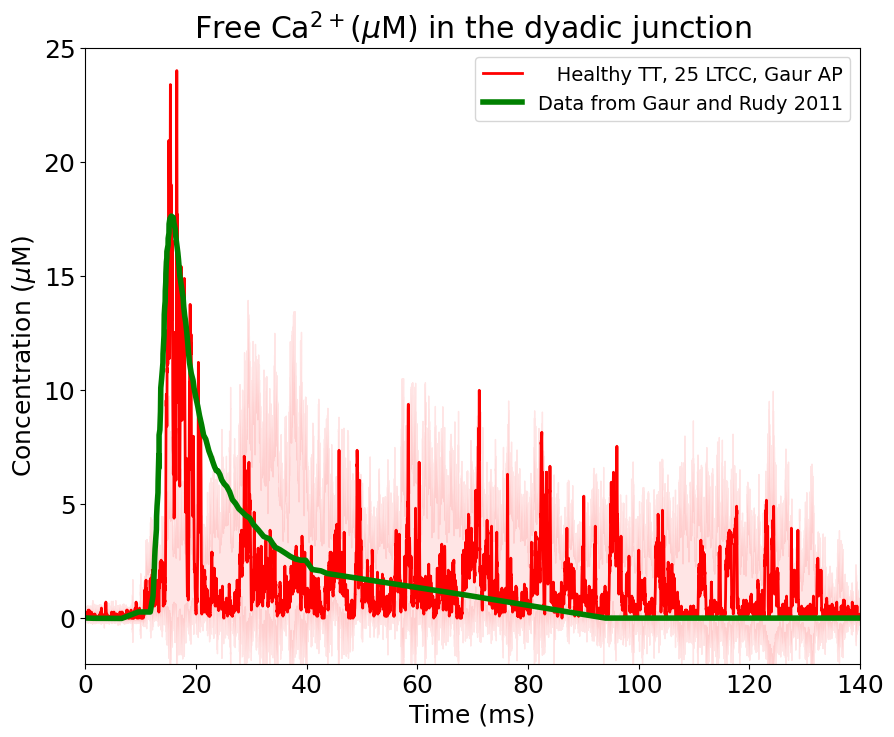

4685

In [93]:
def load_data(file_path):
    data = pd.read_csv(file_path, sep=" ", header=None)
    return data

def normalize_data_to_micromolarity(data, volume_in_cubic_micrometers):
    volume_in_liters = volume_in_cubic_micrometers * 1e-15
    micromolarity_data = (data / (volume_in_liters * 6.022e23)) * 1e6
    return micromolarity_data

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

def plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color):
    volume = healthy_cleft_volume if 'healthy' in condition_folder else deformed_cleft_volume
    
    individual_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.jDyad_sample_volume.dat'
    avg_file_path = f'{base_dir}/{condition_folder}/mcell/output_data/react_data/Ca_cyt.jDyad_sample_volume.avg_stddev.dat'

    individual_data = load_data(individual_file_path)
    time_in_ms = individual_data[0] * 1000
    individual_micromolarity = normalize_data_to_micromolarity(individual_data[1], volume)
    
    window_size = 8
    filtered_individual_micromolarity = moving_average(individual_micromolarity, window_size)
    filtered_time_in_ms = moving_average(time_in_ms, window_size)

    plt.plot(filtered_time_in_ms, filtered_individual_micromolarity, label=label, color=color, linewidth=2)

    avg_data = load_data(avg_file_path)
    avg_time_in_ms = avg_data[0] * 1000
    avg_micromolarity = normalize_data_to_micromolarity(avg_data[1], volume)
    stddev_micromolarity = normalize_data_to_micromolarity(avg_data[2], volume)
    
    plt.fill_between(avg_time_in_ms, avg_micromolarity - stddev_micromolarity, avg_micromolarity + stddev_micromolarity, color=shade_color, alpha=0.1)

base_dir = '/cnl/mcelldata/Sophie/2024'

# Seeds to plot


seed=8

# Plotting setup
plt.figure(figsize=(10, 8))

# Define conditions and their respective colors
conditions = [

#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50d-alt_fact-5_files','   Healthy TT, 50 LTCC,   disease AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50-alt_fact-5_files','Deformed TT, 50 LTCC,   control AP','black',get_lighter_color('black')),
#        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_50d-alt_fact-5_files','Deformed TT, 50 LTCC,  disease AP','green',get_lighter_color('green')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files',' Healthy TT, 50 LTCC,              control AP','red',get_lighter_color('red')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files',' Healthy TT, 25 LTCC,              control AP','lime',get_lighter_color('lime')),
#        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_10-alt_fact-5_files',' Healthy TT, 10 LTCC,              control AP','black',get_lighter_color('black')),
#        ('Hirakis_Gaur_CRU_RyR-Saftenku-healthy-LTCC_50-alt_fact-5_files','   Healthy TT, 50 LTCC,    Gaur AP','red',get_lighter_color('red')),
        ('Hirakis_Gaur_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files','   Healthy TT, 25 LTCC, Gaur AP','red',get_lighter_color('red')),
    
]

# Load Gaur and Rudy's dataset directly without modifying x-values
gaur_and_rudy_data = pd.read_csv('Gaur_and_Rudy_BioPhysJ_2011_Fig3e.csv', delimiter=',', names=['x', 'y'], dtype={'x': np.float64, 'y': np.float64})

# Sort the data if necessary
gaur_and_rudy_data_sorted = gaur_and_rudy_data.sort_values(by='x')

# Define an offset to shift the plot to the right (e.g., by 10 ms)
time_offset = -6  # Adjust this value as necessary
gaur_and_rudy_data_sorted['x'] += time_offset

# Plot the Gaur simulation data with an offset
plt.figure(figsize=(10, 8))

# Plot your other datasets using the existing function
for condition_folder, label, color, shade_color in conditions:
    plot_individual_and_average(base_dir, condition_folder, seed, label, color, shade_color)

# Plot the Gaur data with the applied shift
plt.plot(gaur_and_rudy_data_sorted['x'], gaur_and_rudy_data_sorted['y'], color='green', linewidth=4, label='Data from Gaur and Rudy 2011')


# Customize plot
plt.xlabel('Time (ms)')
plt.ylabel('Concentration ($\mu$M)')
# Customize plot
plt.xlabel('Time (ms)')
plt.xlim(0, 140)
plt.ylim(-2, 25)
#plt.yticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, ])
plt.title('Free Ca$^{2+}$($\mu$M) in the dyadic junction')
plt.legend(loc='upper right', prop={'size': 14})
#plt.savefig(plot_prefix+'Fig10a_ConcCa-spread.png', dpi=300)
#plt.savefig(plot_prefix+'Fig10a_ConcCa-spread.pdf', dpi=300)
plt.legend(loc='upper right', prop={'size': 14})
plt.show()
gc.collect()

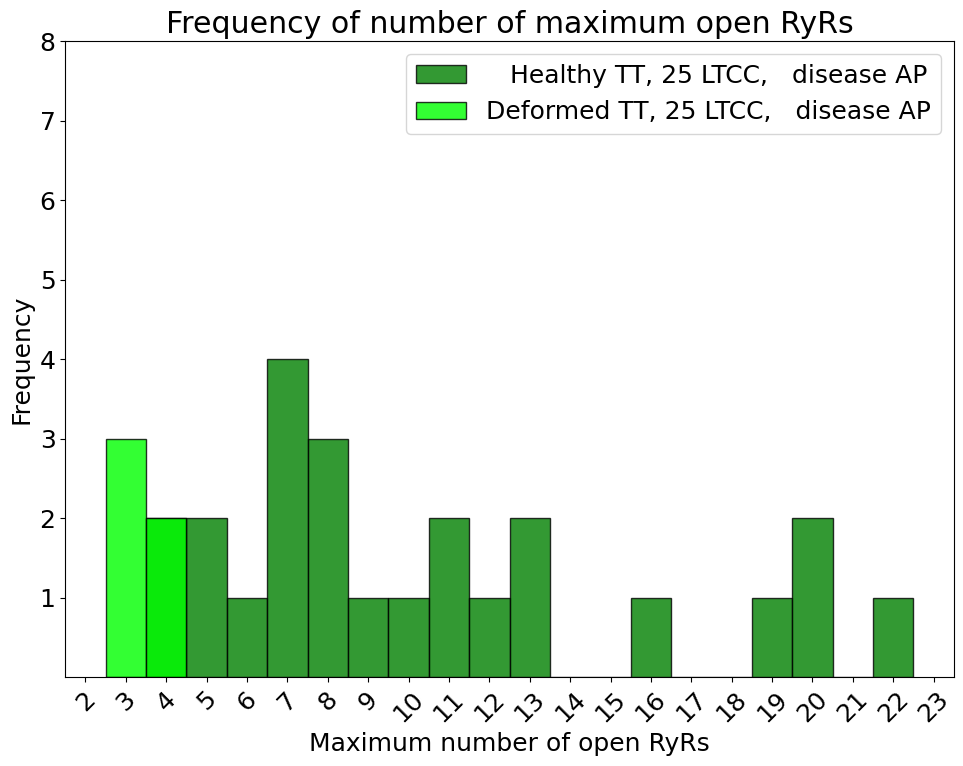

In [94]:
def load_data(file_path):
    try:
        # Load the data
        data = pd.read_csv(file_path, sep=" ", header=None)
        return data
    except FileNotFoundError:
        return None  # Return None if file not found

def get_lighter_color(color, alpha=0.5):
    # Get a lighter shade of the given color
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_overlaid_histograms(base_dir, conditions, num_seeds):
    plt.figure(figsize=(10, 8))  # Increased figure size for better clarity
    max_values = []
    
    # Iterate over each condition and plot in the same figure
    for folder, title, color, _ in conditions:
        max_ryrs = []  # List to store the maximum number of open RyRs for each seed
        for seed in range(1, num_seeds + 1):
            file_paths = [
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO1_L.World.dat',
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO2_L.World.dat',
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO3_L.World.dat',
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO1_H1.World.dat',
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO2_H1.World.dat'
            ]
            
            # Load and sum the data for maximum open RyRs
            total_open_ryrs = None
            for path in file_paths:
                data = load_data(path)
                if data is not None:
                    if total_open_ryrs is None:
                        total_open_ryrs = np.zeros_like(data[1])
                    total_open_ryrs += data[1]
            
            if total_open_ryrs is not None:
                max_ryrs.append(total_open_ryrs.max())

        # Determine bins for histograms if there are any max values to consider
        if max_ryrs:
            max_values.extend(max_ryrs)
            plt.hist(max_ryrs, bins=np.arange(3, max(max_ryrs) + 2) - 0.5, label=title, color=color, alpha=0.8, edgecolor='black', align='mid')

    # Add general histogram settings and display
    if max_values:
        plt.xlabel('Maximum number of open RyRs')
        plt.ylabel('Frequency')
        plt.title('Frequency of number of maximum open RyRs')
        plt.legend(loc='best')
        plt.yticks([1, 2, 3, 4, 5, 6, 7, 8 ])
        # Setting dynamic x-ticks and rotating them for clarity
        x_ticks = np.arange(2, max(max_values) + 2, step=max(1, (max(max_values)-3)//10))  # Adjust step to control frequency
        plt.xticks(x_ticks, rotation=45)  # Rotate x-tick labels to prevent overlap
        plt.tight_layout()  # Optimize layout to prevent clipping of tick-labels
        plt.show()

# Base directory and conditions
base_dir = '/cnl/mcelldata/Sophie/2024'
conditions = [
            ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files','   Healthy TT, 25 LTCC,   disease AP','green',get_lighter_color('green')),
            ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files','Deformed TT, 25 LTCC,   disease AP','lime',get_lighter_color('lime')),
]

num_seeds = 25  # Adjust as needed for each condition

plot_overlaid_histograms(base_dir, conditions, num_seeds)


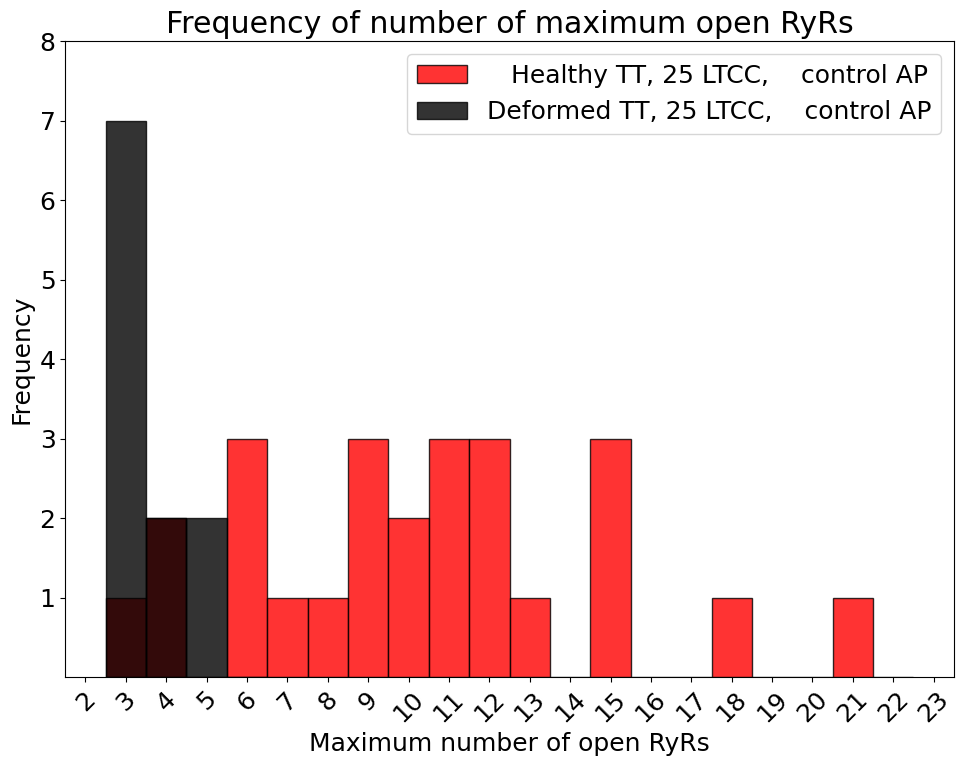

In [95]:

def load_data(file_path):
    try:
        # Load the data
        data = pd.read_csv(file_path, sep=" ", header=None)
        return data
    except FileNotFoundError:
        return None  # Return None if file not found

def get_lighter_color(color, alpha=0.5):
    # Get a lighter shade of the given color
    rgba_color = to_rgba(color)
    return (rgba_color[0], rgba_color[1], rgba_color[2], alpha)

def plot_overlaid_histograms(base_dir, conditions, num_seeds):
    plt.figure(figsize=(10, 8))  # Increased figure size for better clarity
    max_values = []
    
    # Iterate over each condition and plot in the same figure
    for folder, title, color, _ in conditions:
        max_ryrs = []  # List to store the maximum number of open RyRs for each seed
        for seed in range(1, num_seeds + 1):
            file_paths = [
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO1_L.World.dat',
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO2_L.World.dat',
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO3_L.World.dat',
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO1_H1.World.dat',
                f'{base_dir}/{folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/RyRO2_H1.World.dat'
            ]
            
            # Load and sum the data for maximum open RyRs
            total_open_ryrs = None
            for path in file_paths:
                data = load_data(path)
                if data is not None:
                    if total_open_ryrs is None:
                        total_open_ryrs = np.zeros_like(data[1])
                    total_open_ryrs += data[1]
            
            if total_open_ryrs is not None:
                max_ryrs.append(total_open_ryrs.max())

        # Determine bins for histograms if there are any max values to consider
        if max_ryrs:
            max_values.extend(max_ryrs)
            plt.hist(max_ryrs, bins=np.arange(3, max(max_ryrs) + 3) - 0.5, label=title, color=color, alpha=0.8, edgecolor='black', align='mid')

    # Add general histogram settings and display
    if max_values:
        plt.xlabel('Maximum number of open RyRs')
        plt.ylabel('Frequency')
        plt.title('Frequency of number of maximum open RyRs')
        plt.legend(loc='best')
        plt.yticks([1, 2, 3, 4, 5, 6, 7, 8])
        # Setting dynamic x-ticks and rotating them for clarity
        x_ticks = np.arange(2, max(max_values) + 3, step=max(1, (max(max_values)-3)//10))  # Adjust step to control frequency
        plt.xticks(x_ticks, rotation=45)  # Rotate x-tick labels to prevent overlap
        plt.tight_layout()  # Optimize layout to prevent clipping of tick-labels
        plt.show()

# Base directory and conditions
base_dir = '/cnl/mcelldata/Sophie/2024'
conditions = [
        ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files','   Healthy TT, 25 LTCC,    control AP','red',get_lighter_color('red')),
        ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files','Deformed TT, 25 LTCC,    control AP','black',get_lighter_color('black')),
]

num_seeds = 25  # Adjust as needed for each condition

plot_overlaid_histograms(base_dir, conditions, num_seeds)


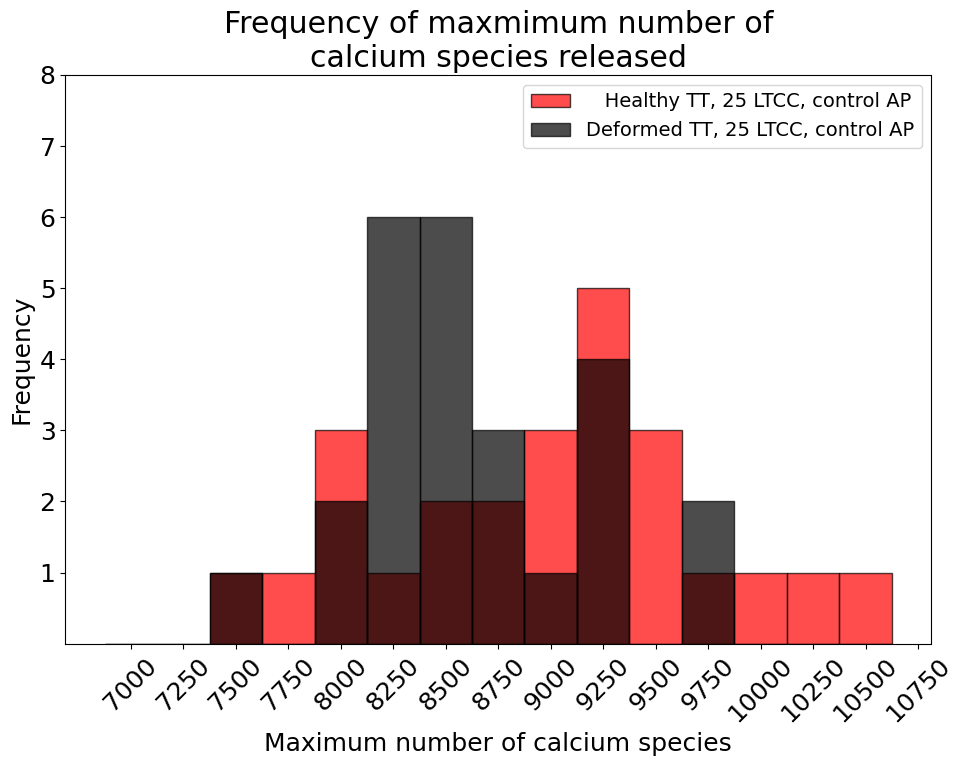

In [96]:
def load_data(file_path):
    try:
        # Load the data
        data = pd.read_csv(file_path, sep=" ", header=None)
        return data[1]  # Assuming the relevant data is in the second column
    except FileNotFoundError:
        # Log the error and return an empty Series
        print(f"Warning: File not found - {file_path}. Continuing with empty data.")
        return pd.Series(dtype='float64')

def plot_summed_calMols_overlay(base_dir, conditions, num_seeds, bin_size=1000):
    plt.figure(figsize=(10, 8))  # Use a larger figure size for better visibility

    max_overall_value = 0  # Track the highest value for bin calculation
    histograms = []  # Store histogram data for plotting

    for condition in conditions:
        condition_folder, label, color, _ = condition
        max_values = []

        for seed in range(1, num_seeds + 1):
            individual_file_paths = [
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X1.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/ATP_Ca.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/CMDN_Ca.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/FLO4_Ca.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/TRPN_Ca.World.dat',
            ]

            total_cal = pd.Series(dtype='float64')
            for path in individual_file_paths:
                data = load_data(path)
                if not data.empty:
                    if total_cal.empty:
                        total_cal = data
                    else:
                        total_cal += data

            if not total_cal.empty:
                max_cal = total_cal.max()
                max_values.append(max_cal)
                if max_cal > max_overall_value:
                    max_overall_value = max_cal

        histograms.append((max_values, label, color))

    # Calculate bins centered around integer multiples of bin_size
    bins = np.arange(7000, 11000, bin_size) - 0.5 * bin_size
    xticks = np.arange(7000, 11000, bin_size)

    for max_values, label, color in histograms:
        plt.hist(max_values, bins=bins, alpha=0.7, label=label, color=color, edgecolor='black', align='mid')

    plt.xlabel('Maximum number of calcium species')
    plt.ylabel('Frequency')
    plt.title('Frequency of maxmimum number of''\ncalcium species released')
    plt.xticks(xticks, rotation=45)
    plt.yticks([1, 2, 3, 4, 5, 6, 7, 8])
    plt.legend(prop={'size': 14})
    plt.tight_layout()
    plt.show()

# Example usage
base_dir = '/cnl/mcelldata/Sophie/2024'
conditions = [
    ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25-alt_fact-5_files', '   Healthy TT, 25 LTCC, control AP', 'red', 'lightcoral'),
    ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25-alt_fact-5_files', 'Deformed TT, 25 LTCC, control AP', 'black', 'black'),
]

num_seeds = 25  # Adjust as needed for each condition
bin_size = 250  # Default bin size

plot_summed_calMols_overlay(base_dir, conditions, num_seeds, bin_size)


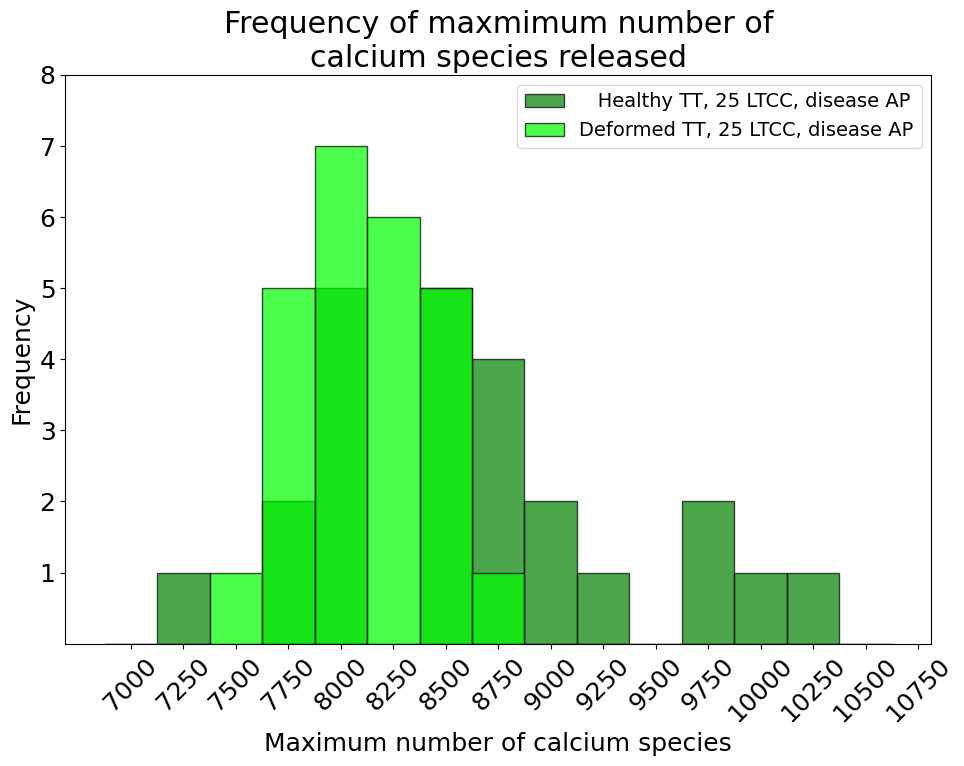

In [97]:
def load_data(file_path):
    try:
        # Load the data
        data = pd.read_csv(file_path, sep=" ", header=None)
        return data[1]  # Assuming the relevant data is in the second column
    except FileNotFoundError:
        # Log the error and return an empty Series
        #print(f"Warning: File not found - {file_path}. Continuing with empty data.")
        return pd.Series(dtype='float64')

def plot_summed_calMols_overlay(base_dir, conditions, num_seeds, bin_size=1000):
    plt.figure(figsize=(10, 8))  # Use a larger figure size for better visibility

    max_overall_value = 0  # Track the highest value for bin calculation
    histograms = []  # Store histogram data for plotting

    for condition in conditions:
        condition_folder, label, color, _ = condition
        max_values = []

        for seed in range(1, num_seeds + 1):
            individual_file_paths = [
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X1.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/SERCA_X2.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/Ca_cyt.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/ATP_Ca.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/CMDN_Ca.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/FLO4_Ca.World.dat',
                f'{base_dir}/{condition_folder}/mcell/output_data/react_data/seed_{str(seed).zfill(5)}/TRPN_Ca.World.dat',
            ]

            total_cal = pd.Series(dtype='float64')
            for path in individual_file_paths:
                data = load_data(path)
                if not data.empty:
                    if total_cal.empty:
                        total_cal = data
                    else:
                        total_cal += data

            if not total_cal.empty:
                max_cal = total_cal.max()
                max_values.append(max_cal)
                if max_cal > max_overall_value:
                    max_overall_value = max_cal

        histograms.append((max_values, label, color))

    # Calculate bins centered around integer multiples of bin_size
    bins = np.arange(7000, 11000, bin_size) - 0.5 * bin_size
    xticks = np.arange(7000, 11000, bin_size)

    for max_values, label, color in histograms:
        plt.hist(max_values, bins=bins, alpha=0.7, label=label, color=color, edgecolor='black', align='mid')

    plt.xlabel('Maximum number of calcium species')
    plt.ylabel('Frequency')
    plt.title('Frequency of maxmimum number of''\ncalcium species released')
    plt.xticks(xticks, rotation=45)
    plt.yticks([1, 2, 3, 4, 5, 6, 7, 8])
    plt.legend(prop={'size': 14})
    plt.tight_layout()
    plt.show()

# Example usage
base_dir = '/cnl/mcelldata/Sophie/2024'
conditions = [
    ('Hirakis_CRU_RyR-Saftenku-healthy-LTCC_25d-alt_fact-5_files', '   Healthy TT, 25 LTCC, disease AP', 'green', 'green'),
    ('Hirakis_CRU_RyR-Saftenku-deformed-LTCC_25d-alt_fact-5_files', 'Deformed TT, 25 LTCC, disease AP', 'lime', 'lime'),
]

num_seeds = 25  # Adjust as needed for each condition
bin_size = 250  # Default bin size

plot_summed_calMols_overlay(base_dir, conditions, num_seeds, bin_size)
